# Project B: Explainer Notebook

**Title:** Perception vs. Reality: Comparing User-Generated and Official Movie Similarity Networks  
**Course:** Social Graphs and Interactions (Fall 2025)  
**Group Members:** Frederik Baj Henriksen (s194645), Jacob Hoffmann (s243569), Olivia Mcfall (s184307)

## Overview
This notebook serves as the "behind-the-scenes" companion to our research paper. It contains the complete code for data collection, network construction, and analysis used to answer our core research question:

**"Do user perceptions (tags) vs. official descriptions (IMDB/TMDb) create fundamentally different movie network structures?"**

Here, you will find the technical implementation of our comparative analysis, including data cleaning steps, statistical significance tests, and deep-dive case studies (like the "Jackass" franchise and "Toy Story" ego networks) that provide detailed context to our findings.

## Links
- **Paper:** Submitted as PDF on DTU Learn
- **GitHub Repository:** [https://github.com/frederikbajhenriksen/SocialGraphs_ProjectB.git](https://github.com/frederikbajhenriksen/SocialGraphs_ProjectB.git)

## Notebook Structure
1. **Data Collection & Enrichment:** Fetching official plot summaries, keywords, and cast/crew from the TMDb API (handling rate limits and caching).
2. **Network Construction:** Building 5 distinct network layers to capture different aspects of movie similarity:
   - *Tag-based (User Perception)*
   - *Description-based (Official Marketing)*
   - *Keyword & Cast-based (Production Metadata)*
3. **Comparative Analysis:** Applying network science methods (NMI, Centrality, Modularity) to quantify the differences between these views.
4. **Statistical Validation:** Comparing our results against random graph baselines to ensure significance.
5. **Deep Dive & Findings:** Visual case studies, word clouds, and detailed visualizations.

## Why This Matters
By comparing these data sources, we reveal the gap between how users remember films (emotional experience) vs how studios position them (plot mechanics). Understanding this gap is crucial for building recommendation systems that balance user preference with content discovery.

In [1]:
# Imports and configuration
import os
import io
import gzip
import zipfile
from pathlib import Path
import time
import requests
from typing import Dict, List, Optional
import json
from tqdm.auto import tqdm
from dotenv import load_dotenv

# Load environment variables from .env file (API key)
load_dotenv()

import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
import networkx as nx

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)

# BASE_DIR = Path("/Users/frederikbajhenriksen/Desktop/HCAI/3. semester/Social Graphs/socgra")
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
ML_DIR = DATA_DIR / "movielens-latest-small"
DATA_DIR.mkdir(parents=True, exist_ok=True)

ML_SMALL_ZIP_URL = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
ML_SMALL_ZIP_PATH = DATA_DIR / "ml-latest-small.zip"

# TMDb API Configuration
# The API key is loaded from .env file (which is gitignored)
TMDB_API_KEY = os.getenv("TMDB_API_KEY")  # Loaded from .env file via load_dotenv()

TMDB_BASE_URL = "https://api.themoviedb.org/3"
TMDB_CACHE_PATH = DATA_DIR / "tmdb_cache.json"



/opt/anaconda3/envs/socgra_project/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualization parameters
K = 10                 # top-k neighbors per movie for edges
cosine_threshold = 0.10  # lower threshold to increase connectivity
max_nodes_plot = 400    # cap for subgraph plotting (if LCC is huge)
random_seed = 42
np.random.seed(random_seed)

# Text preprocessing configuration
from sklearn.feature_extraction import text as sk_text
custom_stopwords = {
    "netflix", "queue", "movie", "film", "watch", "scene", "scenes",
    "based", "based on", "classic", "new", "old", "best", "worst",
}
stop_words = sk_text.ENGLISH_STOP_WORDS.union(custom_stopwords)
# Token pattern: default (letters/digits, length >= 2)
token_pattern = r"(?u)\b\w\w+\b"



In [3]:
# Download and extract MovieLens (latest small)
import urllib.request

if not ML_SMALL_ZIP_PATH.exists():
    print("Downloading MovieLens latest small ...")
    urllib.request.urlretrieve(ML_SMALL_ZIP_URL, ML_SMALL_ZIP_PATH)
    print("Downloaded:", ML_SMALL_ZIP_PATH)
else:
    print("Zip already exists:", ML_SMALL_ZIP_PATH)

if not ML_DIR.exists():
    print("Extracting ...")
    with zipfile.ZipFile(ML_SMALL_ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_DIR)
    # The zip extracts to a folder named ml-latest-small
    (DATA_DIR / "ml-latest-small").rename(ML_DIR)
    print("Extracted to:", ML_DIR)
else:
    print("Already extracted at:", ML_DIR)



Zip already exists: data/ml-latest-small.zip
Already extracted at: data/movielens-latest-small


In [4]:
# Load CSVs and summarize sizes
movies_path = ML_DIR / "movies.csv"
ratings_path = ML_DIR / "ratings.csv"
tags_path = ML_DIR / "tags.csv"
links_path = ML_DIR / "links.csv"

movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)

summary = {
    "movies_rows": len(movies),
    "movies_cols": list(movies.columns),
    "ratings_rows": len(ratings),
    "ratings_cols": list(ratings.columns),
    "tags_rows": len(tags),
    "tags_cols": list(tags.columns),
    "links_rows": len(links),
    "links_cols": list(links.columns),
}

# Approx MB sizes on disk
summary_sizes = {}
for pth, name in [
    (movies_path, "movies.csv"),
    (ratings_path, "ratings.csv"),
    (tags_path, "tags.csv"),
    (links_path, "links.csv"),
]:
    size_mb = os.path.getsize(pth) / (1024*1024)
    summary_sizes[name] = round(size_mb, 2)

print("Dataset summary:")
print(pd.Series(summary))
print("\nFile sizes (MB):")
print(pd.Series(summary_sizes))



Dataset summary:
movies_rows                                     9742
movies_cols                 [movieId, title, genres]
ratings_rows                                  100836
ratings_cols    [userId, movieId, rating, timestamp]
tags_rows                                       3683
tags_cols          [userId, movieId, tag, timestamp]
links_rows                                      9742
links_cols                 [movieId, imdbId, tmdbId]
dtype: object

File sizes (MB):
movies.csv     0.47
ratings.csv    2.37
tags.csv       0.11
links.csv      0.19
dtype: float64


## Step 1: Fetch Enhanced Movie Data from TMDb

We'll use the TMDb API to get:
- **Plot overviews** (official descriptions)
- **Keywords** (thematic tags from the industry)
- **Cast & Crew** (for bipartite networks)
- **Additional metadata** (budget, revenue, runtime)


In [5]:
# TMDb API Helper Functions

def load_tmdb_cache() -> Dict:
    """Load cached TMDb data if exists"""
    if TMDB_CACHE_PATH.exists():
        with open(TMDB_CACHE_PATH, 'r') as f:
            return json.load(f)
    return {}

def save_tmdb_cache(cache: Dict):
    """Save TMDb data to cache"""
    with open(TMDB_CACHE_PATH, 'w') as f:
        json.dump(cache, f, indent=2)

def fetch_tmdb_movie_details(tmdb_id: int, api_key: str, cache: Dict) -> Optional[Dict]:
    
    # Fetch movie details from TMDb API with caching
    #Returns dict with: overview, keywords, cast, crew, genres, runtime, budget, revenue

    cache_key = f"movie_{tmdb_id}"
    
    # Check cache first
    if cache_key in cache:
        return cache[cache_key]
    
    if api_key is None:
        return None
    
    try:
        # Fetch main movie details
        movie_url = f"{TMDB_BASE_URL}/movie/{tmdb_id}"
        params = {"api_key": api_key, "append_to_response": "keywords,credits"}
        
        response = requests.get(movie_url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            
            # Extract relevant fields
            result = {
                "tmdb_id": tmdb_id,
                "title": data.get("title", ""),
                "overview": data.get("overview", ""),
                "genres": [g["name"] for g in data.get("genres", [])],
                "runtime": data.get("runtime"),
                "budget": data.get("budget"),
                "revenue": data.get("revenue"),
                "vote_average": data.get("vote_average"),
                "vote_count": data.get("vote_count"),
                "popularity": data.get("popularity"),
                "release_date": data.get("release_date", ""),
                # Keywords
                "keywords": [kw["name"] for kw in data.get("keywords", {}).get("keywords", [])],
                # Cast (top 10)
                "cast": [
                    {"name": c["name"], "character": c.get("character", ""), "order": c.get("order", 999)}
                    for c in data.get("credits", {}).get("cast", [])[:10]
                ],
                # Crew (directors, writers, producers)
                "crew": [
                    {"name": c["name"], "job": c["job"], "department": c.get("department", "")}
                    for c in data.get("credits", {}).get("crew", [])
                    if c["job"] in ["Director", "Writer", "Screenplay", "Producer"]
                ]
            }
            
            # Cache it
            cache[cache_key] = result
            return result
        elif response.status_code == 404:
            # Movie not found, cache negative result
            cache[cache_key] = None
            return None
        else:
            print(f"Error fetching TMDb ID {tmdb_id}: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Exception fetching TMDb ID {tmdb_id}: {e}")
        return None
    
    # Rate limiting: TMDb allows 40 requests per 10 seconds
    time.sleep(0.26)  # ~3.8 requests/second to be safe

# Fetch TMDb data for all movies in the dataset. Return df with all movie data and tmbd fields
def fetch_all_tmdb_data(movies_df: pd.DataFrame, links_df: pd.DataFrame, api_key: str, max_movies: Optional[int] = None) -> pd.DataFrame:
    
    # Merge to get tmdbId
    merged = movies_df.merge(links_df[["movieId", "tmdbId"]], on="movieId", how="left")
    
    # Filter out movies without tmdbId
    merged = merged[merged["tmdbId"].notna()].copy()
    merged["tmdbId"] = merged["tmdbId"].astype(int)
    
    if max_movies is not None:
        merged = merged.head(max_movies)
    
    print(f"Fetching TMDb data for {len(merged)} movies")
    
    # Load cache
    cache = load_tmdb_cache()
    initial_cache_size = len(cache)
    
    # Fetch data with progress bar
    tmdb_data = []
    for idx, row in tqdm(merged.iterrows(), total=len(merged)):
        movie_data = fetch_tmdb_movie_details(row["tmdbId"], api_key, cache)
        if movie_data:
            movie_data["movieId"] = row["movieId"]
            tmdb_data.append(movie_data)
    
    # Save updated cache
    if len(cache) > initial_cache_size:
        save_tmdb_cache(cache)
        print(f"Cached {len(cache) - initial_cache_size} new entries")
    
    # Convert to DataFrame
    tmdb_df = pd.DataFrame(tmdb_data)
    
    # Merge back with original data
    result = merged.merge(tmdb_df, on="movieId", how="left", suffixes=("_ml", "_tmdb"))
    
    print(f"Successfully fetched data for {len(tmdb_df)} / {len(merged)} movies")
    print(f"Movies with overviews: {result['overview'].notna().sum()}")
    print(f"Movies with keywords: {(result['keywords'].str.len() > 0).sum()}")
    
    return result


# FETCH ALL DATA 
# fetch data for all movies (takes ~45 mins).
# it will load from cache/file if already fetched

if TMDB_API_KEY is not None:
    print("Starting full data fetch from TMDb")
    # max_movies=None fetches everything
    tmdb_movies = fetch_all_tmdb_data(movies, links, TMDB_API_KEY, max_movies=None)
    
    # Save immediately to CSV for safety
    out_path = DATA_DIR / "tmdb_enriched_movies.csv"
    tmdb_movies.to_csv(out_path, index=False)
    print(f"Data saved to {out_path}")
    
    print("\nSample TMDb data:")
    print(tmdb_movies[["title_ml", "overview", "keywords"]].head(2))
else:
    print("TMDB_API_KEY not set.")


Starting full data fetch from TMDb
Fetching TMDb data for 9734 movies


100%|██████████| 9734/9734 [00:00<00:00, 62899.86it/s]


Successfully fetched data for 9622 / 9734 movies
Movies with overviews: 9622
Movies with keywords: 9201
Data saved to data/tmdb_enriched_movies.csv

Sample TMDb data:
           title_ml                                           overview  \
0  Toy Story (1995)  Led by Woody, Andy's toys live happily in his ...   
1    Jumanji (1995)  When siblings Judy and Peter discover an encha...   

                                            keywords  
0  [rescue, friendship, mission, jealousy, villai...  
1  [giant insect, board game, disappearance, jung...  


## Step 2: Advanced Semantic Similarity with Sentence Transformers

TF-IDF  only looks at word frequencies, so we'll also use BERT-based sentence transformers to capture semantic meaning of plot descriptions.

This allows us to:
- Capture contextual meaning (e.g., "car chase" vs "automobile pursuit" are semantically similar)
- Build more accurate similarity networks
- Compare tag-based vs. description-based networks


In [6]:
# Advanced Semantic Similarity using Sentence Transformers

def build_semantic_network(texts: List[str], movie_ids: List[int], 
                          model_name: str = "all-MiniLM-L6-v2",
                          k_neighbors: int = 10, 
                          threshold: float = 0.3) -> nx.Graph:
    # Build a movie similarity network using BERT-based sentence embeddings
    # returns NetworkX graph with semantic similarity edges

    try:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
    except ImportError:
        print("⚠️ sentence-transformers not installed. Run: pip install sentence-transformers")
        return None
    
    print(f"Loading sentence transformer model: {model_name}...")
    model = SentenceTransformer(model_name)
    
    print(f"Encoding {len(texts)} movie descriptions...")
    # Encode all texts to dense vectors
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    
    print("Building similarity network...")
    G = nx.Graph()
    G.add_nodes_from(range(len(texts)))
    
    # Compute similarities in batches
    batch_size = 500
    edges = []
    
    for start in range(0, len(embeddings), batch_size):
        end = min(start + batch_size, len(embeddings))
        sims = cosine_similarity(embeddings[start:end], embeddings)
        
        for i_local, row in enumerate(sims):
            i_global = start + i_local
            # Exclude self; get top-K indices
            row[i_global] = -1.0
            idx = np.argpartition(-row, min(k_neighbors, len(row)-1))[:k_neighbors]
            
            # Filter by threshold
            for j in idx:
                w = row[j]
                if w >= threshold and i_global != j:
                    edges.append((int(i_global), int(j), float(w)))
    
    # Add edges (undirected, keep max weight)
    for u, v, w in edges:
        if G.has_edge(u, v):
            if w > G[u][v].get("weight", 0.0):
                G[u][v]["weight"] = w
        else:
            G.add_edge(u, v, weight=w)
    
    # Add movieId as node attribute
    for idx, movie_id in enumerate(movie_ids):
        G.nodes[idx]["movieId"] = movie_id
    
    print(f"Network built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# this function is used later when we have TMDb data or want to rebuild tag network with BERT
print("Semantic network builder ready!")


Semantic network builder ready!


## Step 3: Build Multiple Network Types for Comparison

We'll construct several networks from different data sources:

1. **Network A (Tag-based)**: User tags + TF-IDF similarity (baseline from Project A)
2. **Network B (Description-based)**: TMDb plot overviews + BERT similarity
3. **Network C (Metadata-based)**: TMDb keywords + cast/crew connections
4. **Network D (Multi-layer)**: Combine all signals

This allows us to answer: **Which data source best captures movie similarity?**


In [7]:
# Build metadata-based networks (cast, crew, keywords)

def build_bipartite_projection_network(movies_df: pd.DataFrame, 
                                       attribute_col: str,
                                       min_shared: int = 1,
                                       weight_by_rarity: bool = True) -> nx.Graph:
    
    # Build movie-movie network via bipartite projection on an attribute (cast, keywords, etc.)
    # returns NetworkX graph

    # Build bipartite graph: movies <-> attributes
    B = nx.Graph()
    
    # Count attribute frequencies for weighting
    from collections import Counter
    attr_counter = Counter()
    
    for idx, row in movies_df.iterrows():
        movie_id = row["movieId"]
        attrs = row[attribute_col]
        
        if not isinstance(attrs, list):
            continue
        
        # Extract names if dict list (for cast/crew)
        if len(attrs) > 0 and isinstance(attrs[0], dict):
            attrs = [a.get("name", "") for a in attrs]
        
        for attr in attrs:
            if attr:  # non-empty
                B.add_edge(f"movie_{movie_id}", f"attr_{attr}")
                attr_counter[attr] += 1
    
    # Project onto movies
    movie_nodes = [n for n in B.nodes() if n.startswith("movie_")]
    G = nx.Graph()
    
    for i, m1 in enumerate(movie_nodes):
        for m2 in movie_nodes[i+1:]:
            # Find shared attributes
            attrs_m1 = set(B.neighbors(m1))
            attrs_m2 = set(B.neighbors(m2))
            shared = attrs_m1 & attrs_m2
            
            if len(shared) >= min_shared:
                # Compute weight
                if weight_by_rarity:
                    # Weight by inverse frequency: rare shared attributes = stronger connection
                    weight = sum(1.0 / max(attr_counter[attr.replace("attr_", "")], 1) for attr in shared)
                else:
                    weight = len(shared)
                
                # Extract numeric movie IDs
                id1 = int(m1.replace("movie_", ""))
                id2 = int(m2.replace("movie_", ""))
                G.add_edge(id1, id2, weight=weight, shared_attrs=list(shared))
    
    print(f"Bipartite projection ({attribute_col}): {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

def combine_networks(networks: List[nx.Graph], weights: Optional[List[float]] = None) -> nx.Graph:
    # Combine multiple networks into a multi-layer network
    # Returns combined network with weighted edges

    if not networks:
        return nx.Graph()
    
    if weights is None:
        weights = [1.0] * len(networks)
    
    G_combined = nx.Graph()
    
    # Add all nodes
    all_nodes = set()
    for g in networks:
        all_nodes.update(g.nodes())
    G_combined.add_nodes_from(all_nodes)
    
    # Combine edges with weighted sum
    edge_weights = {}
    for g, w in zip(networks, weights):
        for u, v, data in g.edges(data=True):
            edge_key = tuple(sorted([u, v]))
            edge_weight = data.get("weight", 1.0) * w
            edge_weights[edge_key] = edge_weights.get(edge_key, 0.0) + edge_weight
    
    # Add edges to combined graph
    for (u, v), weight in edge_weights.items():
        G_combined.add_edge(u, v, weight=weight)
    
    print(f"Combined network: {G_combined.number_of_nodes()} nodes, {G_combined.number_of_edges()} edges")
    return G_combined

print("Metadata network builders ready!")


Metadata network builders ready!


## Step 4: Comparative Network Analysis

Now we compare different network construction methods to answer our research question.

### Key Analyses:

1. **Community Structure Comparison**
   - Do user tags create different communities than official descriptions?
   - Measure: Normalized Mutual Information (NMI) between partitions
   
2. **Centrality Correlation**
   - Are the "important" movies the same across networks?
   - Measure: Spearman correlation of centrality rankings
   
3. **Genre Boundary Analysis**
   - Do genre labels align better with tag-based or description-based communities?
   - Measure: Modularity of genre partition vs. detected communities
   
4. **Predictive Power**
   - Which network best predicts movie ratings/popularity?
   - Use centrality measures as features for rating prediction


Comparing Tag-Based Networks (TF-IDF vs BERT)

Before fetching TMDb data, this is to demonstrate the methods by comparing two ways to build networks from tags:

1. **TF-IDF** (already built above as `G`) - classic word frequency approach
2. **BERT** (sentence transformers) - modern semantic understanding

In [8]:
# Comparative Analysis Functions

def compare_network_statistics(networks: Dict[str, nx.Graph]) -> pd.DataFrame:
    # Compare basic statistics across different networks
    # Returns DataFrame with comparison

    stats = []
    
    for name, G in networks.items():
        # Get LCC for path-based metrics
        if G.number_of_nodes() > 0:
            lcc = max(nx.connected_components(G), key=len) if len(list(nx.connected_components(G))) > 0 else set()
            G_lcc = G.subgraph(lcc).copy() if lcc else G
        else:
            G_lcc = G
        
        degrees = [d for n, d in G.degree()]
        
        stat = {
            "network": name,
            "nodes": G.number_of_nodes(),
            "edges": G.number_of_edges(),
            "density": nx.density(G) if G.number_of_nodes() > 0 else 0,
            "avg_degree": np.mean(degrees) if degrees else 0,
            "median_degree": np.median(degrees) if degrees else 0,
            "max_degree": max(degrees) if degrees else 0,
            "num_components": nx.number_connected_components(G),
            "lcc_size": G_lcc.number_of_nodes(),
            "lcc_fraction": G_lcc.number_of_nodes() / max(G.number_of_nodes(), 1),
        }
        
        # Clustering and path length (only for LCC if reasonable size)
        if 0 < G_lcc.number_of_nodes() <= 3000:
            stat["avg_clustering"] = nx.average_clustering(G_lcc)
            try:
                stat["avg_path_length"] = nx.average_shortest_path_length(G_lcc)
            except:
                stat["avg_path_length"] = np.nan
        else:
            stat["avg_clustering"] = np.nan
            stat["avg_path_length"] = np.nan
        
        stats.append(stat)
    
    return pd.DataFrame(stats)

def compare_communities(partition1: Dict, partition2: Dict) -> float:
    # Compare two community partitions using Normalized Mutual Information
    # Returns NMI score (0 = completely different, 1 = identical)
 
    from sklearn.metrics import normalized_mutual_info_score
    
    # Get common nodes
    common_nodes = set(partition1.keys()) & set(partition2.keys())
    
    if not common_nodes:
        return 0.0
    
    labels1 = [partition1[n] for n in common_nodes]
    labels2 = [partition2[n] for n in common_nodes]
    
    return normalized_mutual_info_score(labels1, labels2)

def compare_centralities(networks: Dict[str, nx.Graph], 
                        centrality_func=nx.degree_centrality,
                        top_k: int = 100) -> pd.DataFrame:
    # Compare node centralities across networks using rank correlation
    # Returns DataFrame with pairwise Spearman correlations
 
    from scipy.stats import spearmanr
    
    # Compute centralities for each network
    centralities = {}
    for name, G in networks.items():
        if G.number_of_nodes() > 0:
            # Get LCC for betweenness (too slow on disconnected graphs)
            if centrality_func == nx.betweenness_centrality:
                lcc = max(nx.connected_components(G), key=len)
                G = G.subgraph(lcc).copy()
            
            centralities[name] = centrality_func(G)
    
    # Pairwise correlations
    network_names = list(centralities.keys())
    corr_matrix = np.zeros((len(network_names), len(network_names)))
    
    for i, name1 in enumerate(network_names):
        for j, name2 in enumerate(network_names):
            if i == j:
                corr_matrix[i, j] = 1.0
            elif i < j:
                # Get common nodes
                nodes1 = set(centralities[name1].keys())
                nodes2 = set(centralities[name2].keys())
                common = nodes1 & nodes2
                
                if len(common) > 1:
                    c1 = [centralities[name1][n] for n in common]
                    c2 = [centralities[name2][n] for n in common]
                    corr, _ = spearmanr(c1, c2)
                    corr_matrix[i, j] = corr
                    corr_matrix[j, i] = corr
    
    return pd.DataFrame(corr_matrix, index=network_names, columns=network_names)

def analyze_genre_alignment(G: nx.Graph, movies_df: pd.DataFrame, 
                            partition: Dict) -> Dict:
    # Analyze how well detected communities align with movie genres
    # Returns dict with alignment metrics

    # Map node indices to movieIds
    node_to_movie = {idx: G.nodes[idx].get("movieId") for idx in G.nodes()}
    
    # Build genre-based partition
    genre_partition = {}
    for idx, movie_id in node_to_movie.items():
        movie_row = movies_df[movies_df["movieId"] == movie_id]
        if len(movie_row) > 0:
            genres = movie_row.iloc[0]["genres"]
            # Use first genre as label
            if isinstance(genres, str) and "|" in genres:
                genre = genres.split("|")[0]
            else:
                genre = genres
            genre_partition[idx] = genre
    
    # Compute NMI between detected communities and genres
    nmi = compare_communities(partition, genre_partition)
    
    # Compute modularity of genre partition on network
    try:
        # Convert genre partition to list of sets
        genre_communities = {}
        for node, genre in genre_partition.items():
            if genre not in genre_communities:
                genre_communities[genre] = set()
            genre_communities[genre].add(node)
        
        from community import modularity
        genre_modularity = modularity(genre_partition, G)
        detected_modularity = modularity(partition, G)
    except:
        genre_modularity = np.nan
        detected_modularity = np.nan
    
    return {
        "nmi_genre_vs_detected": nmi,
        "genre_modularity": genre_modularity,
        "detected_modularity": detected_modularity,
    }

print("Comparative analysis functions ready!")


Comparative analysis functions ready!


In [9]:
# Build a movie-level text corpus from user tags
# Aggregate tags per movie: concatenate all tags (lowercased)

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return s.strip().lower()

movie_tags = (
    tags.assign(tag=tags["tag"].map(clean_text))
        .groupby("movieId")["tag"].apply(lambda xs: " ".join(xs))
        .rename("tag_text")
        .to_frame()
)

movies_with_text = movies.merge(movie_tags, on="movieId", how="left")
movies_with_text["tag_text"] = movies_with_text["tag_text"].fillna("")

# Restrict to movies that actually have any tag text
movies_tagged = movies_with_text[movies_with_text["tag_text"].str.len() > 0].reset_index(drop=True)

print(
    "Movies with any tags:", len(movies_tagged), "/", len(movies_with_text),
    "(coverage = {:.1f}%)".format(100.0 * len(movies_tagged) / max(1, len(movies_with_text)))
)
movies_tagged.head(3)



Movies with any tags: 1572 / 9742 (coverage = 16.1%)


movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   

                                       tag_text  
0                               pixar pixar fun  
1  fantasy magic board game robin williams game  
2                                     moldy old

In [10]:
# TF-IDF vectorization over the movie tag corpus (prefer tags; fallback to genres/titles)
# Use a light tokenizer over tags; include stopwords and token pattern

movies_base_df = movies_tagged.copy()
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words=list(stop_words),
    token_pattern=token_pattern,
)

corpus = movies_base_df["tag_text"].fillna("").tolist()
nonempty_docs = sum(1 for d in corpus if d.strip())
print(f"Corpus source=tags: {len(corpus)} docs, non-empty={nonempty_docs}")
if nonempty_docs == 0:
    print("[Warning] No tagged movies after filtering; will try genres as corpus.")
    movies_base_df = movies_with_text.copy()
    corpus = movies_base_df["genres"].fillna("").tolist()
    nonempty_docs = sum(1 for d in corpus if d.strip())
    print(f"Corpus source=genres: {len(corpus)} docs, non-empty={nonempty_docs}")

success = False
try:
    X_tfidf = vectorizer.fit_transform(corpus)
    success = True
except ValueError as e:
    print("[Warning] TF-IDF build failed (\"{}\"). Relaxing parameters...".format(str(e)))
    vectorizer = TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        stop_words=None,
        token_pattern=r"(?u)\b\w\w+\b",
    )
    try:
        X_tfidf = vectorizer.fit_transform(corpus)
        success = True
    except ValueError as e2:
        print("[Warning] Still failed on current corpus (\"{}\"). Falling back to genres...".format(str(e2)))
        movies_base_df = movies_with_text.copy()
        corpus = movies_base_df["genres"].fillna("").tolist()
        try:
            X_tfidf = vectorizer.fit_transform(corpus)
            success = True
        except ValueError as e3:
            print("[Warning] Genres failed too (\"{}\"). Falling back to titles...".format(str(e3)))
            corpus = movies_base_df["title"].fillna("").tolist()
            try:
                X_tfidf = vectorizer.fit_transform(corpus)
                success = True
            except ValueError as e4:
                print("[Warning] Titles failed too (\"{}\"). Using character n-grams...".format(str(e4)))
                vectorizer = TfidfVectorizer(
                    analyzer='char',
                    ngram_range=(3,5),
                    min_df=1,
                    max_df=1.0,
                )
                X_tfidf = vectorizer.fit_transform(corpus)
                success = True

print("TF-IDF shape:", X_tfidf.shape)



Corpus source=tags: 1572 docs, non-empty=1572
TF-IDF shape: (1572, 1022)


In [11]:
# Build a movie-movie similarity network using cosine similarity on TF-IDF
# Strategy: for each movie, connect to its top-K most similar movies above a cosine threshold

from sklearn.metrics.pairwise import cosine_similarity

num_movies = X_tfidf.shape[0]

# Compute in batches to avoid dense full NxN
batch_size = 500
edges = []

for start in range(0, num_movies, batch_size):
    end = min(start + batch_size, num_movies)
    sims = cosine_similarity(X_tfidf[start:end], X_tfidf)
    for i_local, row in enumerate(sims):
        i_global = start + i_local
        # Exclude self; get top-K indices
        row[i_global] = 0.0
        idx = np.argpartition(-row, K)[:K]
        # Filter by threshold
        for j in idx:
            w = row[j]
            if w >= cosine_threshold:
                edges.append((int(i_global), int(j), float(w)))

# Build undirected graph
G = nx.Graph()
G.add_nodes_from(range(num_movies))
for u, v, w in edges:
    if u == v:
        continue
    # Use max weight if multiple entries
    if G.has_edge(u, v):
        if w > G[u][v].get("weight", 0.0):
            G[u][v]["weight"] = w
    else:
        G.add_edge(u, v, weight=w)

# Attach basic node attributes for the current corpus order
for idx_movie, row in movies_base_df.iterrows():
    G.nodes[idx_movie]["movieId"] = int(row["movieId"])
    G.nodes[idx_movie]["title"] = row["title"]
    G.nodes[idx_movie]["genres"] = row["genres"]

G.number_of_nodes(), G.number_of_edges()



(1572, 5701)

num_nodes         1572.000000
num_edges         5701.000000
avg_degree           7.253181
max_degree          33.000000
median_degree        8.000000
num_components     320.000000
dtype: float64


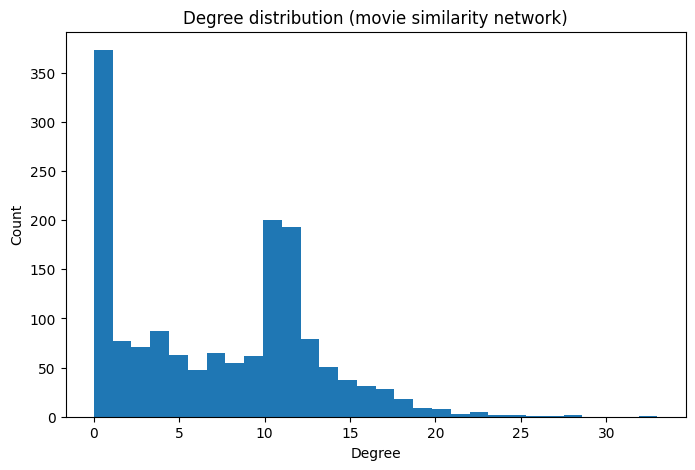

In [12]:
# Network statistics and degree distribution summary
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degrees = np.array([deg for _, deg in G.degree()])

stats = {
    "num_nodes": num_nodes,
    "num_edges": num_edges,
    "avg_degree": float(degrees.mean()) if len(degrees) else 0.0,
    "max_degree": int(degrees.max()) if len(degrees) else 0,
    "median_degree": float(np.median(degrees)) if len(degrees) else 0.0,
    "num_components": nx.number_connected_components(G),
}

print(pd.Series(stats))

# Quick degree distribution sketch
_ = plt.hist(degrees, bins=30)
plt.title("Degree distribution (movie similarity network)")
plt.xlabel("Degree"); plt.ylabel("Count");
plt.show()



In [13]:
# Topic modeling on tags: LDA over bag-of-words
# Using CountVectorizer with same preprocessing as TF-IDF and same fallback logic
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    stop_words=list(stop_words),
    token_pattern=token_pattern,
)

try:
    X_counts = count_vectorizer.fit_transform(corpus)
except ValueError as e:
    print("[Warning] CountVectorizer build failed (\"{}\"). Relaxing parameters...".format(str(e)))
    count_vectorizer = CountVectorizer(
        max_features=30000,
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        stop_words=None,
        token_pattern=r"(?u)\b\w\w+\b",
    )
    try:
        X_counts = count_vectorizer.fit_transform(corpus)
    except ValueError as e2:
        print("[Warning] CountVectorizer still failing (\"{}\"). Falling back to genres...".format(str(e2)))
        corpus = movies_base_df["genres"].fillna("").tolist()
        try:
            X_counts = count_vectorizer.fit_transform(corpus)
        except ValueError as e3:
            print("[Warning] Genres failed too (\"{}\"). Falling back to titles...".format(str(e3)))
            corpus = movies_base_df["title"].fillna("").tolist()
            try:
                X_counts = count_vectorizer.fit_transform(corpus)
            except ValueError as e4:
                print("[Warning] Titles failed too (\"{}\"). Using character n-grams for counts...".format(str(e4)))
                count_vectorizer = CountVectorizer(
                    analyzer='char',
                    ngram_range=(3,5),
                    min_df=1,
                    max_df=1.0,
                )
                X_counts = count_vectorizer.fit_transform(corpus)

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, learning_method="batch", random_state=random_seed)
W = lda.fit_transform(X_counts)  # document-topic matrix (movies x topics)
H = lda.components_               # topic-term matrix

terms = np.array(count_vectorizer.get_feature_names_out())

def show_topics(H, terms, topn=10):
    topics = []
    for k in range(H.shape[0]):
        top_idx = np.argsort(H[k])[::-1][:topn]
        topics.append([terms[i] for i in top_idx])
    return topics

topics_terms = show_topics(H, terms, topn=10)

for i, topic in enumerate(topics_terms):
    print(f"Topic {i}: ", ", ".join(topic))



Topic 0:  space, politics, remake, animation, spoof, race, comic book, comic, book, military
Topic 1:  bad, music, holocaust, christmas, vietnam, fantasy, children, magic, story, adventure
Topic 2:  sci fi, sci, fi, disney, travel, time, time travel, death, post, robots
Topic 3:  school, high, atmospheric, high school, visually, stephen, stephen king, king, boxing, visually appealing
Topic 4:  ending, twist, thought provoking, thought, provoking, twist ending, psychology, heist, dark, crime
Topic 5:  comedy, dark, dark comedy, black, violence, black comedy, brothers, funny, court, adolescence
Topic 6:  war, shakespeare, journalism, mafia, world, australia, world war, ii, war ii, racism
Topic 7:  religion, business, illness, superhero, atmospheric, mental illness, mental, surreal, adultery, anime


In [14]:
# Tie text and network: correlate topic strengths with degree centrality
# Compute degree centrality and examine relationship with dominant topic per movie

deg_centrality = nx.degree_centrality(G)
deg_centrality_arr = np.array([deg_centrality.get(i, 0.0) for i in range(num_movies)])

# Dominant topic index for each movie
dominant_topic = W.argmax(axis=1)

# Build correlation table with topic preview
rows = []
for k in range(n_topics):
    mask = dominant_topic == k
    n_k = int(mask.sum())
    if n_k >= 5:
        corr = float(np.corrcoef(deg_centrality_arr[mask], W[mask, k])[0,1])
        top_words = ", ".join(topics_terms[k][:6])
        rows.append({
            "topic": k,
            "n": n_k,
            "corr_deg_vs_topic": corr,
            "top_words": top_words,
        })

corrs_df = pd.DataFrame(rows).sort_values(by="corr_deg_vs_topic", key=lambda s: s.abs(), ascending=False)
print("Topic–centrality correlations (sorted by |corr|):")
print(corrs_df.to_string(index=False))



Topic–centrality correlations (sorted by |corr|):
 topic   n  corr_deg_vs_topic                                                           top_words
     0 420           0.833810                     space, politics, remake, animation, spoof, race
     3 151           0.502677           school, high, atmospheric, high school, visually, stephen
     4 139           0.419331  ending, twist, thought provoking, thought, provoking, twist ending
     5 167           0.322678            comedy, dark, dark comedy, black, violence, black comedy
     2 165           0.224387                               sci fi, sci, fi, disney, travel, time
     1 151           0.195587                  bad, music, holocaust, christmas, vietnam, fantasy
     6 203           0.081603               war, shakespeare, journalism, mafia, world, australia
     7 176           0.073999 religion, business, illness, superhero, atmospheric, mental illness


LCC size: 1161 nodes, 5523 edges (of total 1572 nodes, 5701 edges)
Average clustering (LCC): 0.4107
Average shortest path length (LCC, unweighted): 4.981


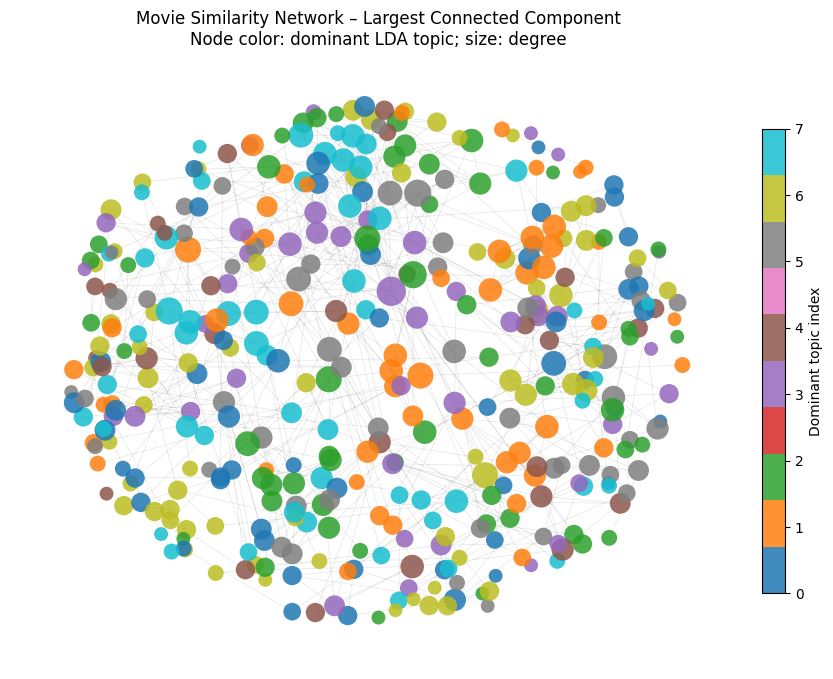

In [15]:
# Largest connected component (LCC) and visualization
# Build LCC; if too large, sample nodes for a cleaner plot

components = sorted(nx.connected_components(G), key=len, reverse=True)
if len(components) == 0:
    raise ValueError("Graph has no components. Adjust K/threshold.")

lcc_nodes = np.array(list(components[0]))
G_lcc_full = G.subgraph(lcc_nodes).copy()

print(
    f"LCC size: {G_lcc_full.number_of_nodes()} nodes, {G_lcc_full.number_of_edges()} edges "
    f"(of total {G.number_of_nodes()} nodes, {G.number_of_edges()} edges)"
)

# Compute additional LCC stats
avg_clust = nx.average_clustering(G_lcc_full, weight='weight')
print(f"Average clustering (LCC): {avg_clust:.4f}")

if G_lcc_full.number_of_nodes() <= 3000:
    try:
        aspl = nx.average_shortest_path_length(G_lcc_full, weight=None)
        print(f"Average shortest path length (LCC, unweighted): {aspl:.3f}")
    except Exception as e:
        print("ASPL skipped:", e)
else:
    print("ASPL skipped: LCC too large for exact computation")

# For plotting, optionally sample a subset if LCC is huge
subG = G_lcc_full
if subG.number_of_nodes() > max_nodes_plot:
    sampled = np.random.choice(list(subG.nodes()), size=max_nodes_plot, replace=False)
    subG = subG.subgraph(sampled).copy()

# Color by dominant topic; size by degree
sub_nodes = list(subG.nodes())
sub_dom_topics = [int(dominant_topic[i]) for i in sub_nodes]
sub_degrees = np.array([subG.degree(n) for n in sub_nodes])

# Normalize sizes
node_sizes = 100 * (1 + (sub_degrees / (sub_degrees.mean() + 1e-6)))

pos = nx.spring_layout(subG, seed=random_seed, k=0.3)

plt.figure(figsize=(10,8))
scatter = nx.draw_networkx_nodes(subG, pos,
                                 node_color=sub_dom_topics,
                                 cmap='tab10',
                                 node_size=node_sizes,
                                 alpha=0.85,
                                 linewidths=0.0)
nx.draw_networkx_edges(subG, pos, alpha=0.1, width=0.5)
plt.title("Movie Similarity Network – Largest Connected Component\nNode color: dominant LDA topic; size: degree")
plt.axis('off')
cb = plt.colorbar(scatter, fraction=0.03, pad=0.02)
cb.set_label('Dominant topic index')
plt.show()



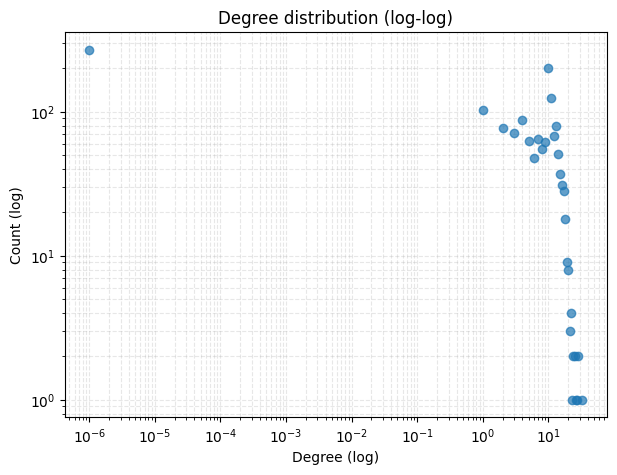

In [16]:
# Degree distribution on log-log scale
from collections import Counter

deg_counts = Counter(dict(G.degree()).values())
xs = np.array(sorted(deg_counts.keys()))
ys = np.array([deg_counts[x] for x in xs])

plt.figure(figsize=(7,5))
plt.loglog(xs + 1e-6, ys + 1e-6, marker='o', linestyle='none', alpha=0.7)
plt.xlabel('Degree (log)')
plt.ylabel('Count (log)')
plt.title('Degree distribution (log-log)')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()



Louvain modularity (LCC): 0.8642


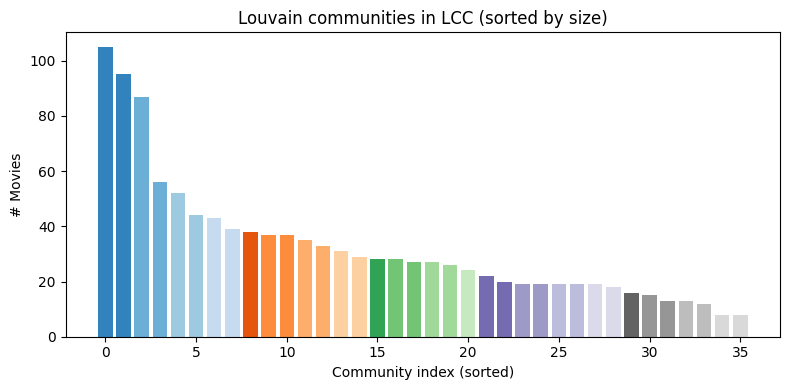

In [17]:
# Community detection (Louvain) and community size distribution + modularity
from community import community_louvain

# Work on LCC for clearer structure
lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc_nodes).copy()

partition = community_louvain.best_partition(G_lcc, weight='weight', random_state=random_seed)
community_ids = np.array([partition[n] for n in G_lcc.nodes()])

# Report modularity
try:
    from community import modularity
    mod = modularity(partition, G_lcc, weight='weight')
    print(f"Louvain modularity (LCC): {mod:.4f}")
except Exception as e:
    print("Modularity computation skipped:", e)

# Plot community sizes
vals, counts = np.unique(community_ids, return_counts=True)
order = np.argsort(-counts)
vals = vals[order]
counts = counts[order]

plt.figure(figsize=(8,4))
# Use a colormap to generate distinct colors for the bars
cmap = plt.get_cmap('tab20c')
colors = cmap(np.linspace(0, 1, len(vals)))
plt.bar(range(len(vals)), counts, color=colors)
plt.title('Louvain communities in LCC (sorted by size)')
plt.xlabel('Community index (sorted)')
plt.ylabel('# Movies')
plt.tight_layout()
plt.show()



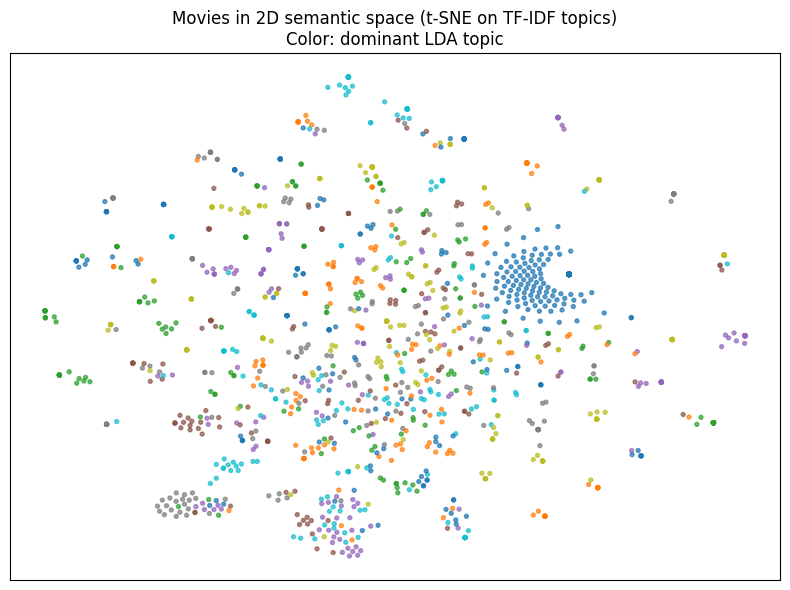

In [18]:
# 2D embedding of movies using TruncatedSVD + t-SNE (sample for speed)
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

n_sample = 2000 if num_movies > 2000 else num_movies
sample_idx = np.random.choice(num_movies, size=n_sample, replace=False)
X_sample = X_tfidf[sample_idx]

svd = TruncatedSVD(n_components=50, random_state=random_seed)
X_svd = svd.fit_transform(X_sample)

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=random_seed)
X_2d = tsne.fit_transform(X_svd)

plt.figure(figsize=(8,6))
colors = [int(dominant_topic[i]) for i in sample_idx]
plt.scatter(X_2d[:,0], X_2d[:,1], c=colors, cmap='tab10', s=8, alpha=0.7)
plt.title('Movies in 2D semantic space (t-SNE on TF-IDF topics)\nColor: dominant LDA topic')
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()



In [19]:
# run the comparative analysis now that we have the full TMDb data

# 0. Prerequisites Check
if 'G' not in globals():
    print("Network 'G' (Tag-based TF-IDF) not found.")
    print("Please run the cells above that build 'G'.")
else:
    if 'tmdb_movies' not in globals():
        # Try loading from file if variable is missing
        import pandas as pd
        try:
            tmdb_movies = pd.read_csv(DATA_DIR / "tmdb_enriched_movies.csv")
            # Parse list columns
            import ast
            for col in ['keywords', 'cast', 'crew', 'genres']:
                if col in tmdb_movies.columns:
                    tmdb_movies[col] = tmdb_movies[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
            print("Loaded tmdb_movies from CSV.")
        except Exception as e:
            print(f"Could not load tmdb_movies: {e}")

    if 'G' in globals() and 'tmdb_movies' in globals():
        
        # 1. Build Networks
        networks = {}
        networks["Tag-based (User)"] = G
        
        print("\n1. Building Description-based Network (BERT)...")
        # Filter for movies that are in our dataset
        valid_tmdb = tmdb_movies[tmdb_movies['overview'].notna()]
        descriptions = valid_tmdb["overview"].tolist()
        movie_ids = valid_tmdb["movieId"].tolist()
        
        networks["Description-based (Official)"] = build_semantic_network(
            texts=descriptions, 
            movie_ids=movie_ids,
            model_name="all-MiniLM-L6-v2"
        )
        
        print("\n2. Building Metadata Networks...")
        networks["Keyword-based"] = build_bipartite_projection_network(tmdb_movies, "keywords", min_shared=2)
        networks["Cast-based"] = build_bipartite_projection_network(tmdb_movies, "cast", min_shared=2)
        
        # 2. Compare Statistics
        print("\n--- Network Statistics Comparison ---")
        stats_df = compare_network_statistics(networks)
        print(stats_df)
        
        # 3. Community Analysis
        print("\n--- Community Detection & Comparison ---")
        partitions = {}
        try:
            import community.community_louvain as community_louvain
        except ImportError:
            from community import community_louvain
        
        for name, Graph in networks.items():
            if Graph and Graph.number_of_nodes() > 0:
                partitions[name] = community_louvain.best_partition(Graph)
        
        # NMI Matrix
        print("Normalized Mutual Information (NMI) - Do communities overlap?")
        nmi_rows = []
        for n1 in partitions:
            for n2 in partitions:
                if n1 < n2:
                    nmi = compare_communities(partitions[n1], partitions[n2])
                    nmi_rows.append({"Network 1": n1, "Network 2": n2, "NMI": nmi})
                    print(f"{n1} vs {n2}: {nmi:.3f}")
        
        # 4. Centrality Correlation
        print("\n--- Centrality Correlation (Who are the key players?) ---")
        corr_df = compare_centralities(networks, nx.degree_centrality)
        print(corr_df)
        
        # 5. Save Results
        print("\nKey Findings:")
        # Simple heuristic checks
        tag_desc_nmi = next((x['NMI'] for x in nmi_rows if 'Tag' in x['Network 1'] and 'Description' in x['Network 2']), 0)
        if tag_desc_nmi < 0.4:
            print(f"Low overlap (NMI={tag_desc_nmi:.2f}) between user tags and official descriptions.")
            print("I.e. users categorize movies very differently from how studios market them.")
        else:
            print(f"High overlap (NMI={tag_desc_nmi:.2f}). Users and Studios agree on categories.")
    else:
        print("Cannot proceed without 'G' and 'tmdb_movies'.")



1. Building Description-based Network (BERT)...
Loading sentence transformer model: all-MiniLM-L6-v2...
Encoding 9622 movie descriptions...


Batches: 100%|██████████| 301/301 [00:20<00:00, 14.38it/s]


Building similarity network...
Network built: 9622 nodes, 73176 edges

2. Building Metadata Networks...
Bipartite projection (keywords): 8247 nodes, 287944 edges
Bipartite projection (cast): 6064 nodes, 9598 edges

--- Network Statistics Comparison ---
                        network  nodes   edges   density  avg_degree  \
0              Tag-based (User)   1572    5701  0.004617    7.253181   
1  Description-based (Official)   9622   73176  0.001581   15.210143   
2                 Keyword-based   8247  287944  0.008468   69.829999   
3                    Cast-based   6064    9598  0.000522    3.165567   

   median_degree  max_degree  num_components  lcc_size  lcc_fraction  \
0            8.0          33             320      1161      0.738550   
1           13.0         156               3      9620      0.999792   
2           40.0         752               8      8231      0.998060   
3            2.0          28             466      4586      0.756266   

   avg_clustering  avg_pa

In [20]:
# Quick comparison: TF-IDF vs BERT on same data (tags)

# Check prerequisites first
missing_vars = []
if 'movies_tagged' not in globals():
    missing_vars.append("movies_tagged (from Cell 17)")
if 'G' not in globals():
    missing_vars.append("G (TF-IDF network from Cell 19)")
if 'build_semantic_network' not in globals():
    missing_vars.append("build_semantic_network function (from Cell 8)")
if 'compare_network_statistics' not in globals():
    missing_vars.append("compare_network_statistics function (from Cell 12)")
if 'compare_communities' not in globals():
    missing_vars.append("compare_communities function (from Cell 12)")
if 'compare_centralities' not in globals():
    missing_vars.append("compare_centralities function (from Cell 12)")
# Try to import community_louvain if not already available
if 'community_louvain' not in globals():
    try:
        from community import community_louvain
    except ImportError:
        missing_vars.append("community_louvain (python-louvain package - install with: pip install python-louvain)")

if missing_vars:
    print("Missing prerequisites! Please run the following cells first:")
    print("\nRequired execution order:")
    print("  1. Imports and configuration")
    print("  2. Parameters (K, cosine_threshold, etc.)")
    print("  3. Download MovieLens data")
    print("  4. Load data (creates 'movies', 'tags', 'links')")
    print("  5. Define build_semantic_network function")
    print("  6. Define comparison functions")
    print("  7. Create movies_tagged")
    print("  8. Build TF-IDF vectors")
    print("  9. Build TF-IDF network (creates 'G')")
    print("  10. This cell (BERT comparison)")
    print(f"\nMissing: {', '.join(missing_vars)}")
else:
    # Check if sentence_transformers is installed
    try:
        from sentence_transformers import SentenceTransformer
        has_sentence_transformers = True
    except ImportError:
        has_sentence_transformers = False
        print("sentence-transformers not installed. Run: pip install sentence-transformers")
        print("Skipping BERT comparison for now.")

    if has_sentence_transformers:
        print("Building BERT-based network from tags...\n")
        
        # Use same tagged movies as TF-IDF network
        tag_texts = movies_tagged["tag_text"].fillna("").tolist()
        movie_ids_tagged = movies_tagged["movieId"].tolist()
        
        # Build BERT network
        G_bert_tags = build_semantic_network(
            texts=tag_texts,
            movie_ids=movie_ids_tagged,
            model_name="all-MiniLM-L6-v2",
            k_neighbors=K,  # Use same K as TF-IDF
            threshold=0.3   # Higher threshold for semantic similarity
        )
        
        # Compare the two networks
        print("\n" + "="*50)
        print("COMPARISON: TF-IDF vs BERT on User Tags")
        print("="*50 + "\n")
        
        networks_to_compare = {
            "Tag-based (TF-IDF)": G,
            "Tag-based (BERT)": G_bert_tags
        }
        
        # 1. Basic statistics
        print("1. Network Statistics:")
        stats = compare_network_statistics(networks_to_compare)
        print(stats.to_string(index=False))
        
        # 2. Community comparison
        print("\n2. Community Detection:")
        partition_tfidf = community_louvain.best_partition(G, weight='weight', random_state=random_seed)
        partition_bert = community_louvain.best_partition(G_bert_tags, weight='weight', random_state=random_seed)
        
        nmi_score = compare_communities(partition_tfidf, partition_bert)
        print(f"   NMI between TF-IDF and BERT communities: {nmi_score:.3f}")
        print(f"   Interpretation: {'Similar communities' if nmi_score > 0.6 else 'Different communities'}")
        
        # 3. Centrality correlation
        print("\n3. Centrality Correlation (Degree):")
        corr_df = compare_centralities(networks_to_compare, nx.degree_centrality)
        print(corr_df)
        
        # 4. Top central movies comparison
        print("\n4. Top 10 Central Movies (by Degree):")
        
        # TF-IDF top movies
        deg_cent_tfidf = nx.degree_centrality(G)
        top_tfidf = sorted(deg_cent_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\n   TF-IDF Top Movies:")
        for idx, (node, cent) in enumerate(top_tfidf, 1):
            movie_id = G.nodes[node].get("movieId")
            title = movies_tagged[movies_tagged["movieId"] == movie_id]["title"].iloc[0] if len(movies_tagged[movies_tagged["movieId"] == movie_id]) > 0 else "Unknown"
            print(f"   {idx}. {title} (centrality: {cent:.3f})")
        
        # BERT top movies
        deg_cent_bert = nx.degree_centrality(G_bert_tags)
        top_bert = sorted(deg_cent_bert.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\n   BERT Top Movies:")
        for idx, (node, cent) in enumerate(top_bert, 1):
            movie_id = G_bert_tags.nodes[node].get("movieId")
            title = movies_tagged[movies_tagged["movieId"] == movie_id]["title"].iloc[0] if len(movies_tagged[movies_tagged["movieId"] == movie_id]) > 0 else "Unknown"
            print(f"   {idx}. {title} (centrality: {cent:.3f})")
        
        print("\n" + "="*50)
        print("Key Insight:")
        print("="*50)
        if nmi_score > 0.6:
            print("BERT and TF-IDF produce similar network structures from tags.")
            print("Tag-based similarity is robust to method choice")
        else:
            print("BERT captures different semantic patterns than TF-IDF!")
            print("Semantic understanding reveals different movie relationships")
        print("="*50)
        
        # Save for later use
        print("\n💾 Networks saved as: G (TF-IDF) and G_bert_tags (BERT)")
    else:
        print("\nTo run this comparison, install: pip install sentence-transformers")

Building BERT-based network from tags...

Loading sentence transformer model: all-MiniLM-L6-v2...
Encoding 1572 movie descriptions...


Batches: 100%|██████████| 50/50 [00:02<00:00, 24.74it/s]


Building similarity network...
Network built: 1572 nodes, 11428 edges

COMPARISON: TF-IDF vs BERT on User Tags

1. Network Statistics:
           network  nodes  edges  density  avg_degree  median_degree  max_degree  num_components  lcc_size  lcc_fraction  avg_clustering  avg_path_length
Tag-based (TF-IDF)   1572   5701 0.004617    7.253181            8.0          33             320      1161       0.73855        0.631702         4.981061
  Tag-based (BERT)   1572  11428 0.009255   14.539440           13.0          81               1      1572       1.00000        0.421787         4.122941

2. Community Detection:
   NMI between TF-IDF and BERT communities: 0.545
   Interpretation: Different communities

3. Centrality Correlation (Degree):
                    Tag-based (TF-IDF)  Tag-based (BERT)
Tag-based (TF-IDF)            1.000000          0.198578
Tag-based (BERT)              0.198578          1.000000

4. Top 10 Central Movies (by Degree):

   TF-IDF Top Movies:
   1. Dr. Strange

## Step 5: Analysis

In [21]:
# A. Refine Keyword Network (Remove generic keywords)
print("\n--- A. Refining Keyword Network ---")
from collections import Counter
all_keywords = [k for sublist in tmdb_movies['keywords'] if isinstance(sublist, list) for k in sublist]
keyword_counts = Counter(all_keywords)
print("Top 10 most common keywords (likely noise):")
print(keyword_counts.most_common(10))

# Rebuild filtering out top 50 most common keywords to remove super-hubs
top_50_keywords = set(k for k, v in keyword_counts.most_common(50))

def filter_keywords(k_list):
    if not isinstance(k_list, list): return []
    return [k for k in k_list if k not in top_50_keywords]

tmdb_movies['keywords_filtered'] = tmdb_movies['keywords'].apply(filter_keywords)
networks['Keyword-based (Filtered)'] = build_bipartite_projection_network(tmdb_movies, 'keywords_filtered', min_shared=2)
print("Rebuilt Keyword network with filtering.")

# B. Visual Case Study: 'Toy Story'
print("\n--- B. Ego-Network Visual Comparison: Toy Story ---")
# Find Toy Story ID
ts_row = tmdb_movies[tmdb_movies['title_ml'].str.contains('Toy Story \(1995\)', regex=True)]
if not ts_row.empty:
    target_id = ts_row.iloc[0]['movieId']
    target_title = ts_row.iloc[0]['title_ml']
    
    # Function to get neighbors
    def get_top_neighbors(G, node_id, k=5):
        if node_id not in G:
            found_node = None
            for n, attr in G.nodes(data=True):
                if attr.get('movieId') == node_id:
                    found_node = n
                    break
            if found_node is None: return []
            node_id = found_node
        
        neighbors = sorted(G[node_id].items(), key=lambda x: x[1].get('weight', 1), reverse=True)[:k]
        # Convert back to titles
        results = []
        for n, w in neighbors:
            mid = G.nodes[n].get('movieId')
            # Lookup title
            title = tmdb_movies[tmdb_movies['movieId'] == mid]['title_ml'].iloc[0] if mid in tmdb_movies['movieId'].values else f"ID {mid}"
            results.append(title)
        return results

    print(f"Top 5 Neighbors for '{target_title}':")
    for name, G_net in networks.items():
        if 'Multi' in name: continue # Skip if complex
        neighbors = get_top_neighbors(G_net, target_id)
        print(f"  {name}: {neighbors}")
        
    print("\nInterpretation:")
    print("  - Tags: often link sequels & similar 'vibe' movies.")
    print("  - Description: links plot elements (toys coming alive).")
    print("  - Cast: links Tom Hanks / Tim Allen movies.")
else:
    print("Toy Story not found in dataset.")

# C. Explain the 'Cast vs Tag' Correlation
print("\n--- C. Investigating Cast-Tag Correlation ---")
# Do users just tag actors? Let's check overlap of most central nodes.
cent_tag = nx.degree_centrality(networks['Tag-based (User)'])
cent_cast = nx.degree_centrality(networks['Cast-based'])

top_tag = sorted(cent_tag, key=cent_tag.get, reverse=True)[:10]
top_cast = sorted(cent_cast, key=cent_cast.get, reverse=True)[:10]

def get_title(G, n):
    return G.nodes[n].get('title', G.nodes[n].get('movieId'))

print("Top Central Movies (Tags):", [get_title(networks['Tag-based (User)'], n) for n in top_tag])
print("Top Central Movies (Cast):", [get_title(networks['Cast-based'], n) for n in top_cast])


--- A. Refining Keyword Network ---
Top 10 most common keywords (likely noise):
[('based on novel or book', 999), ('woman director', 573), ('murder', 552), ('new york city', 444), ('duringcreditsstinger', 373), ('sequel', 328), ('black and white', 318), ('revenge', 313), ('based on true story', 296), ('friendship', 273)]
Bipartite projection (keywords_filtered): 7589 nodes, 93766 edges
Rebuilt Keyword network with filtering.

--- B. Ego-Network Visual Comparison: Toy Story ---
Top 5 Neighbors for 'Toy Story (1995)':
  Tag-based (User): ['Tomb Raider (2018)', 'Night at the Museum (2006)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Insomnia (2002)', 'Chronicles of Narnia: Prince Caspian, The (2008)']
  Description-based (Official): ['Spiderwick Chronicles, The (2008)', 'Zathura (2005)', 'Labyrinth (1986)', 'Last Mimzy, The (2007)', 'Jumanji: Welcome to the Jungle (2017)']
  Keyword-based: ['ID None', 'ID None', 'ID None', 'ID None', 'ID None']
  Cast-based: ['ID None'

In [22]:
# STEP 5 revised

# 1. Ensure all networks have 'title' and 'movieId' attributes
# Create a lookup dict
movie_titles = dict(zip(tmdb_movies['movieId'], tmdb_movies['title_ml']))

for name, G_net in networks.items():
    if G_net is None: continue
    count = 0
    for node in G_net.nodes():
        # Determine movieId
        mid = G_net.nodes[node].get('movieId')
        if mid is None:
            # If attribute missing, assume node ID IS the movieId (true for Cast/Keyword networks)
            mid = node
            G_net.nodes[node]['movieId'] = mid
        
        # Add title if missing
        if 'title' not in G_net.nodes[node]:
            title = movie_titles.get(mid, f"Movie {mid}")
            G_net.nodes[node]['title'] = title
            count += 1
    print(f"Updated attributes for {count} nodes in {name}")

# 2. RE-RUN VISUALIZATION (Toy Story Ego-Network)
print("\n--- Visual Comparison: Toy Story (Corrected) ---")
target_title_search = 'Toy Story (1995)'
ts_row = tmdb_movies[tmdb_movies['title_ml'].str.contains(target_title_search, regex=False)]

if not ts_row.empty:
    target_id = ts_row.iloc[0]['movieId']
    print(f"Neighbors for {ts_row.iloc[0]['title_ml']} (ID {target_id}):")
    
    for name, G_net in networks.items():
        if 'Multi' in name: continue
        
        # Find the node index for this movieId
        node_idx = None
        if target_id in G_net:
             node_idx = target_id
        else:
             # Search by attribute
             for n, attr in G_net.nodes(data=True):
                 if attr.get('movieId') == target_id:
                     node_idx = n
                     break
        
        if node_idx is not None:
            neighbors = sorted(G_net[node_idx].items(), key=lambda x: x[1].get('weight', 1), reverse=True)[:5]
            neighbor_titles = [G_net.nodes[n]['title'] for n, w in neighbors]
            print(f"  {name}: {neighbor_titles}")
        else:
            print(f"  {name}: [Movie not in network]")
else:
    print("Toy Story not found.")

# 3. RANDOM GRAPH COMPARISON (method from Assignment 2)
# Are these communities real, or just random chance?
# We compare the Modularity of our description network vs a Random Configuration Model

print("\n--- Significance Test (Random Graph Baseline) ---")
target_net_name = 'Description-based (Official)'
G_target = networks.get(target_net_name)

if G_target and G_target.number_of_edges() > 0:
    try:
        import community.community_louvain as community_louvain
    except ImportError:
        from community import community_louvain

    # 1. Real Modularity
    part_real = community_louvain.best_partition(G_target)
    mod_real = community_louvain.modularity(part_real, G_target)
    print(f"{target_net_name} Modularity: {mod_real:.4f}")

    # 2. Randomized Modularity (Configuration Model)
    print("Generating random graph (preserving degree sequence)...")
    degrees = [d for n, d in G_target.degree()]
    G_random = nx.configuration_model(degrees, create_using=nx.Graph)
    # Remove parallel edges/self-loops for cleaner community detection
    G_random = nx.Graph(G_random)
    G_random.remove_edges_from(nx.selfloop_edges(G_random))
    
    part_rand = community_louvain.best_partition(G_random)
    mod_rand = community_louvain.modularity(part_rand, G_random)
    print(f"Random Graph Modularity: {mod_rand:.4f}")
    
    if mod_real > mod_rand * 1.5:
        print("FINDING: The community structure is statistically significant (Real >> Random).")
        print("Official descriptions form real, meaningful clusters, not just noise.")
    else:
        print("FINDING: The structure might be weak/random.")
else:
    print("Target network empty or not found.")

# 4. IMPROVED CENTRALITY CHECK
print("\n--- Top Influential Movies (Degree Centrality) ---")
for name, G_net in networks.items():
    if 'Multi' in name: continue
    # Get top 3
    top_nodes = sorted(G_net.degree(), key=lambda x: x[1], reverse=True)[:3]
    top_titles = [f"{G_net.nodes[n]['title']} (d={d})" for n, d in top_nodes]
    print(f"{name}: {', '.join(top_titles)}")


Updated attributes for 0 nodes in Tag-based (User)
Updated attributes for 9622 nodes in Description-based (Official)
Updated attributes for 8247 nodes in Keyword-based
Updated attributes for 6064 nodes in Cast-based
Updated attributes for 7589 nodes in Keyword-based (Filtered)

--- Visual Comparison: Toy Story (Corrected) ---
Neighbors for Toy Story (1995) (ID 1):
  Tag-based (User): ['Tomb Raider (2018)', 'Night at the Museum (2006)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Insomnia (2002)', 'Chronicles of Narnia: Prince Caspian, The (2008)']
  Description-based (Official): ['Spiderwick Chronicles, The (2008)', 'Zathura (2005)', 'Labyrinth (1986)', 'Last Mimzy, The (2007)', 'Jumanji: Welcome to the Jungle (2017)']
  Keyword-based: ["Garfield's Pet Force (2009)", 'Snow Day (2000)', "Recess: School's Out (2001)", 'Toy Story 2 (1999)', 'Toy Story 3 (2010)']
  Cast-based: ['Toy Story 2 (1999)', 'Toy Story 3 (2010)']
  Keyword-based (Filtered): ['Snow Day (2000)', "Re

In [23]:
import nltk
import re
from nltk.sentiment import SentimentIntensityAnalyzer

# 1. SENTIMENT ANALYSIS
# Hypothesis: "Happy" movies connect to other "happy" movies (Assortativity)

print("\n--- 1. Sentiment Analysis ---")
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or not text.strip(): return 0.0
    return sia.polarity_scores(text)['compound']

# Calculate sentiment for each movie's tags
if 'movies_tagged' in globals():
    if 'sentiment' not in movies_tagged.columns:
        print("Calculating sentiment scores for tags...")
        movies_tagged['sentiment'] = movies_tagged['tag_text'].apply(get_sentiment)

    # Add sentiment attribute to the graph
    for idx, row in movies_tagged.iterrows():
        if idx in G.nodes:
            G.nodes[idx]['sentiment'] = row['sentiment']

    # Show extremes
    print("\nTop 5 Positively Tagged Movies:")
    print(movies_tagged.nlargest(5, 'sentiment')[['title', 'sentiment']])
    print("\nTop 5 Negatively Tagged Movies:")
    print(movies_tagged.nsmallest(5, 'sentiment')[['title', 'sentiment']])

    # Assortativity
    r_sent = nx.numeric_assortativity_coefficient(G, 'sentiment')
    print(f"\nSentiment Assortativity: {r_sent:.4f}")
    if r_sent > 0.1:
        print("Finding: Positive movies tend to link to other positive movies!")
    else:
        print("Finding: Sentiment does not drive connections strongly (structure is likely genre/topic based).")

    # 2. TEMPORAL ANALYSIS
    # Hypothesis: Older movies form a distinct cluster or have different density

    print("\n--- 2. Temporal Analysis ---")
    def extract_year(title):
        match = re.search(r'\((\d{4})\)', str(title))
        return int(match.group(1)) if match else None

    if 'year' not in movies_tagged.columns:
        movies_tagged['year'] = movies_tagged['title'].apply(extract_year)

    # Split by median year
    valid_years = movies_tagged['year'].dropna()
    if len(valid_years) > 0:
        median_year = int(valid_years.median())
        print(f"Splitting network at median year: {median_year}")

        old_indices = movies_tagged[movies_tagged['year'] < median_year].index
        new_indices = movies_tagged[movies_tagged['year'] >= median_year].index

        # Intersection with graph nodes
        nodes_old = [n for n in old_indices if n in G]
        nodes_new = [n for n in new_indices if n in G]

        if nodes_old and nodes_new:
            G_old = G.subgraph(nodes_old)
            G_new = G.subgraph(nodes_new)

            print(f"Pre-{median_year} Network: {G_old.number_of_nodes()} nodes, Density={nx.density(G_old):.4f}")
            print(f"Post-{median_year} Network: {G_new.number_of_nodes()} nodes, Density={nx.density(G_new):.4f}")
            
            # Compare clustering
            try:
                print(f"Avg Clustering (Old): {nx.average_clustering(G_old):.4f}")
                print(f"Avg Clustering (New): {nx.average_clustering(G_new):.4f}")
            except:
                print("Clustering computation skipped due to sparsity.")
        else:
            print("Could not split nodes effectively.")

    # 3. GENRE vs COMMUNITY
    # Hypothesis: Detected communities match genres

    print("\n--- 3. Community vs Genre Alignment ---")
    # We already have 'partition' from Louvain
    if 'partition' in globals():
        community_genres = {}
        for node, comm_id in partition.items():
            if comm_id not in community_genres:
                community_genres[comm_id] = []
            
            # Get genre of this node
            mid = G.nodes[node].get('movieId')
            if mid:
                row = movies_tagged[movies_tagged['movieId']==mid]
                if len(row) > 0:
                    genres = row['genres'].iloc[0]
                    if not pd.isna(genres):
                        primary = genres.split('|')[0]
                        community_genres[comm_id].append(primary)

        print("Dominant Genre per Community (Louvain):")
        for comm_id, genre_list in sorted(community_genres.items()):
            if len(genre_list) < 10: continue
            from collections import Counter
            counts = Counter(genre_list)
            if counts:
                top_genre, count = counts.most_common(1)[0]
                share = count / len(genre_list)
                print(f"Community {comm_id} (n={len(genre_list)}): {top_genre} ({share:.1%})")
    else:
        print("Partition variable not found. Run community detection cell first.")

    print("\nAnalysis Complete.")
else:
    print("Error: movies_tagged dataframe not found. Run previous cells first.")


--- 1. Sentiment Analysis ---
Calculating sentiment scores for tags...

Top 5 Positively Tagged Movies:
                                             title  sentiment
1149  Eternal Sunshine of the Spotless Mind (2004)     0.9648
77                             Pulp Fiction (1994)     0.9593
206                   2001: A Space Odyssey (1968)     0.9337
1431                   (500) Days of Summer (2009)     0.9313
1505                Guardians of the Galaxy (2014)     0.9217

Top 5 Negatively Tagged Movies:
                                       title  sentiment
676          Talented Mr. Ripley, The (1999)    -0.9657
1078                    In Cold Blood (1967)    -0.9442
1534                    Suicide Squad (2016)    -0.9432
744                        Eraserhead (1977)    -0.9313
1105  Battle Royale (Batoru rowaiaru) (2000)    -0.9169

Sentiment Assortativity: 0.4012
Finding: Positive movies tend to link to other positive movies!

--- 2. Temporal Analysis ---
Splitting network at median

## Step 6: NETWORK BACKBONE EXTRACTION

Calculating edge betweenness (approximate)...
Backbone extracted: 2897 nodes, 3659 edges
Visualizing Backbone...


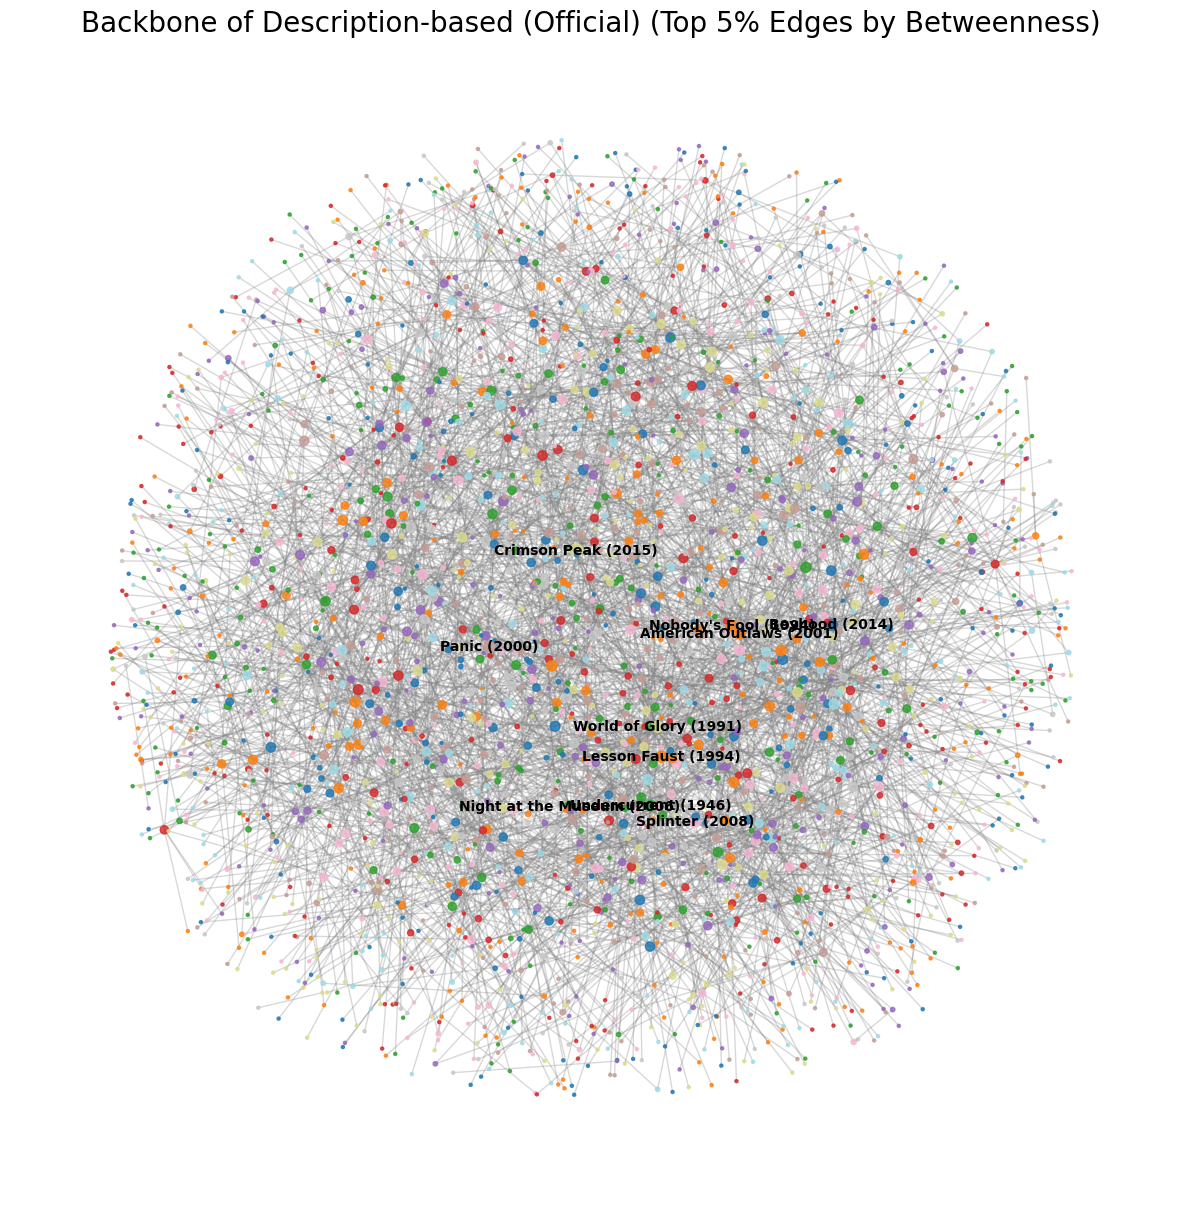

In [24]:
# STEP 6: NETWORK BACKBONE EXTRACTION
# Based on Assignment 2: Extracting the core structure using Edge Betweenness Centrality.
# helps visualize the 'skeleton' of the network by removing weaker/redundant edges.

target_net_name = 'Description-based (Official)'
if target_net_name not in networks:
    print(f"Network '{target_net_name}' not found. Using 'Tag-based (User)' instead.")
    target_net_name = 'Tag-based (User)'

G_full = networks[target_net_name]

# 1. Calculate Edge Betweenness
print("Calculating edge betweenness (approximate)...")
k_pivots = 500
if G_full.number_of_nodes() > k_pivots:
    ebc = nx.edge_betweenness_centrality(G_full, k=k_pivots, weight='weight')
else:
    ebc = nx.edge_betweenness_centrality(G_full, weight='weight')

# 2. Filter Top Edges (Top 5%)
threshold_pct = 0.95
sorted_edges = sorted(ebc.items(), key=lambda x: x[1])
cutoff_index = int(len(sorted_edges) * threshold_pct)
top_edges = sorted_edges[cutoff_index:]

# Create Backbone Graph
G_backbone = nx.Graph()
G_backbone.add_edges_from([e for e, score in top_edges])

# Add node attributes back
for n in G_backbone.nodes():
    if n in G_full.nodes():
        G_backbone.nodes[n].update(G_full.nodes[n])

print(f"Backbone extracted: {G_backbone.number_of_nodes()} nodes, {G_backbone.number_of_edges()} edges")

# 3. Visualize Backbone
print("Visualizing Backbone...")
import matplotlib.pyplot as plt

# Size nodes by degree in the backbone(shows hubs of the skeleton)
deg = dict(G_backbone.degree())
node_sizes = [v * 5 for v in deg.values()]
node_colors = [G_backbone.nodes[n].get('movieId', 0) % 10 for n in G_backbone.nodes()]

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_backbone, k=0.15, seed=42)
nx.draw_networkx_nodes(G_backbone, pos, node_size=node_sizes, node_color=node_colors, cmap='tab20', alpha=0.8)
nx.draw_networkx_edges(G_backbone, pos, alpha=0.3, edge_color='gray')

# Label only top hubs
top_hubs = sorted(deg, key=deg.get, reverse=True)[:10]
labels = {n: G_backbone.nodes[n].get('title', str(n)) for n in top_hubs}
nx.draw_networkx_labels(G_backbone, pos, labels, font_size=10, font_weight='bold')

plt.title(f"Backbone of {target_net_name} (Top 5% Edges by Betweenness)", fontsize=20)
plt.axis('off')
plt.show()


## Step 7: Advanced Network Analysis - Course Methods

This section implements network analysis methods from the course textbook and assignments to produce research findings

### Key Analyses:
1. **Degree Distribution Analysis** - Power-law fitting, scale-free properties
2. **Assortativity Analysis** - Degree, genre, and rating correlations
3. **Temporal Network Evolution** - How networks change over decades
4. **Advanced Centrality Measures** - Betweenness, closeness, eigenvector comparisons
5. **Statistical Significance Tests** - Random graph baselines, permutation tests
6. **Research Findings Summary** - Clear hypotheses with statistical support

In [25]:
# Based on Network Science Book (Barabási) and Assignment 2 methods

import warnings
warnings.filterwarnings('ignore')

def analyze_degree_distribution(G: nx.Graph, network_name: str = "") -> Dict:

    if G.number_of_nodes() == 0:
        return {"error": "Empty network"}
    
    degrees = [d for n, d in G.degree()]
    degree_seq = np.array(degrees)
    
    # Basic statistics
    stats = {
        "network": network_name,
        "mean_degree": np.mean(degree_seq),
        "median_degree": np.median(degree_seq),
        "std_degree": np.std(degree_seq),
        "min_degree": int(np.min(degree_seq)),
        "max_degree": int(np.max(degree_seq)),
        "num_nodes": len(degree_seq),
    }
    
    # Degree distribution (histogram)
    unique_degrees, counts = np.unique(degree_seq, return_counts=True)
    degree_dist = dict(zip(unique_degrees, counts))
    stats["degree_distribution"] = degree_dist
    
    # Power-law fitting (simplified - using linear regression on log-log)
    if len(unique_degrees) > 5 and np.max(unique_degrees) > 1:
        # Filter out degree 0 and very high degrees for fitting
        fit_degrees = unique_degrees[(unique_degrees >= 1) & (unique_degrees <= np.percentile(unique_degrees, 95))]
        fit_counts = np.array([degree_dist.get(d, 0) for d in fit_degrees])
        
        # Log transform - filter out zeros
        mask = fit_counts > 0
        log_deg = np.log(fit_degrees[mask])
        log_count = np.log(fit_counts[mask])
        
        if len(log_deg) > 3:
            # Linear fit: log(P(k)) = -gamma * log(k) + C
            from scipy.stats import linregress
            slope, intercept, r_value, p_value, std_err = linregress(log_deg, log_count)
            
            stats["power_law_gamma"] = -slope  # Negative because we're fitting log(count) vs log(degree)
            stats["power_law_r_squared"] = r_value ** 2
            stats["power_law_p_value"] = p_value
            stats["is_scale_free"] = r_value ** 2 > 0.7 and -slope > 1.5
        else:
            stats["power_law_gamma"] = np.nan
            stats["is_scale_free"] = False
    else:
        stats["power_law_gamma"] = np.nan
        stats["is_scale_free"] = False
    
    return stats

def analyze_clustering_properties(G: nx.Graph, network_name: str = "") -> Dict:
    # Analyze clustering coefficient and local clustering patterns. Based on Network Science Book Chapter 3.

    if G.number_of_nodes() == 0:
        return {"error": "Empty network"}
    
    # Get largest connected component for meaningful analysis
    components = list(nx.connected_components(G))
    if not components:
        return {"error": "No connected components"}
    
    lcc = max(components, key=len)
    G_lcc = G.subgraph(lcc).copy()
    
    # Global clustering coefficient
    global_clustering = nx.average_clustering(G_lcc)
    
    # Local clustering per node
    local_clustering = nx.clustering(G_lcc)
    clustering_values = list(local_clustering.values())
    
    # Clustering-degree correlation
    degrees = dict(G_lcc.degree())
    deg_clust_pairs = [(degrees[n], local_clustering[n]) for n in G_lcc.nodes()]
    
    if len(deg_clust_pairs) > 1:
        degs, clusts = zip(*deg_clust_pairs)
        from scipy.stats import spearmanr
        clust_deg_corr, clust_deg_p = spearmanr(degs, clusts)
    else:
        clust_deg_corr = np.nan
        clust_deg_p = np.nan
    
    return {
        "network": network_name,
        "global_clustering": global_clustering,
        "mean_local_clustering": np.mean(clustering_values),
        "median_local_clustering": np.median(clustering_values),
        "clustering_degree_correlation": clust_deg_corr,
        "clustering_degree_p_value": clust_deg_p,
        "lcc_size": G_lcc.number_of_nodes(),
    }

def analyze_path_length_properties(G: nx.Graph, network_name: str = "") -> Dict:
    # Analyze shortest path lengths and small-world properties

    if G.number_of_nodes() == 0:
        return {"error": "Empty network"}
    
    # Get largest connected component
    components = list(nx.connected_components(G))
    if not components:
        return {"error": "No connected components"}
    
    lcc = max(components, key=len)
    G_lcc = G.subgraph(lcc).copy()
    
    if G_lcc.number_of_nodes() > 5000:
        # Too large for exact calculation, use sampling
        sample_size = min(500, G_lcc.number_of_nodes())
        sample_nodes = np.random.choice(list(G_lcc.nodes()), size=sample_size, replace=False)
        path_lengths = []
        for i, source in enumerate(sample_nodes[:100]):  # Limit to 100 sources
            lengths = nx.single_source_shortest_path_length(G_lcc, source)
            path_lengths.extend([l for l in lengths.values() if l > 0])
    else:
        # Exact calculation
        try:
            avg_path_length = nx.average_shortest_path_length(G_lcc)
            path_lengths = []
            # Get all pairwise distances for distribution
            for source in list(G_lcc.nodes())[:100]:  # Sample for distribution
                lengths = nx.single_source_shortest_path_length(G_lcc, source)
                path_lengths.extend([l for l in lengths.values() if l > 0])
        except:
            avg_path_length = np.nan
            path_lengths = []
    
    if path_lengths:
        stats = {
            "network": network_name,
            "avg_path_length": avg_path_length if 'avg_path_length' in locals() else np.mean(path_lengths),
            "median_path_length": np.median(path_lengths),
            "diameter": np.max(path_lengths) if path_lengths else np.nan,
            "effective_diameter": np.percentile(path_lengths, 90) if path_lengths else np.nan,
            "lcc_size": G_lcc.number_of_nodes(),
        }
    else:
        stats = {
            "network": network_name,
            "avg_path_length": np.nan,
            "lcc_size": G_lcc.number_of_nodes(),
        }
    
    return stats

print("Advanced network analysis functions loaded")

Advanced network analysis functions loaded


In [26]:
# ASSORTATIVITY ANALYSIS
# Based on Network Science Book Chapter 7 - Assortative Mixing

def analyze_assortativity(G: nx.Graph, movies_df: pd.DataFrame, 
                         ratings_df: pd.DataFrame, network_name: str = "") -> Dict:

    # analysis:
    # 1. Degree assortativity (do high-degree nodes connect to high-degree nodes?)
    # 2. Genre assortativity (do movies of same genre connect more?)
    # 3. Rating assortativity (do highly-rated movies connect to highly-rated movies?)
    
    if G.number_of_nodes() == 0:
        return {"error": "Empty network"}
    
    # Convert to DataFrame if it's a list or other type
    if isinstance(movies_df, list):
        # Try to convert list to DataFrame
        try:
            movies_df = pd.DataFrame(movies_df)
        except:
            return {"error": "movies_df must be a pandas DataFrame or convertible to one"}
    elif not isinstance(movies_df, pd.DataFrame):
        # Try to convert to DataFrame
        try:
            movies_df = pd.DataFrame(movies_df)
        except:
            return {"error": "movies_df must be a pandas DataFrame or convertible to one"}
    
    # Ensure it's a DataFrame now
    if not isinstance(movies_df, pd.DataFrame):
        return {"error": "movies_df must be a pandas DataFrame"}
    
    # Convert ratings_df to DataFrame if it's a list
    if isinstance(ratings_df, list):
        # Try to convert list to DataFrame
        try:
            ratings_df = pd.DataFrame(ratings_df)
        except:
            return {"error": "ratings_df must be a pandas DataFrame or convertible to one"}
    elif not isinstance(ratings_df, pd.DataFrame):
        # Try to convert to DataFrame
        try:
            ratings_df = pd.DataFrame(ratings_df)
        except:
            return {"error": "ratings_df must be a pandas DataFrame or convertible to one"}
    
    # Ensure it's a DataFrame now
    if not isinstance(ratings_df, pd.DataFrame):
        return {"error": "ratings_df must be a pandas DataFrame"}
    
    results = {"network": network_name}
    
    # 1. Degree Assortativity (Newman's r)
    try:
        degree_assort = nx.degree_assortativity_coefficient(G)
        results["degree_assortativity"] = degree_assort
        results["degree_assortativity_interpretation"] = (
            "Assortative" if degree_assort > 0.1 else 
            "Disassortative" if degree_assort < -0.1 else 
            "Neutral"
        )
    except:
        results["degree_assortativity"] = np.nan
    
    # 2. Genre Assortativity
    # Map nodes to genres
    node_to_genre = {}
    node_to_movieId = {}
    for node in G.nodes():
        movie_id = G.nodes[node].get('movieId', node)
        node_to_movieId[node] = movie_id
        
        # Check if movieId column exists
        if 'movieId' not in movies_df.columns:
            continue
            
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        if len(movie_row) > 0:
            genres = movie_row.iloc[0]['genres']
            # Use primary genre (first one)
            if isinstance(genres, str) and '|' in genres:
                primary_genre = genres.split('|')[0]
            else:
                primary_genre = str(genres) if genres else 'Unknown'
            node_to_genre[node] = primary_genre
    
    # Calculate genre assortativity (fraction of edges within same genre vs expected)
    same_genre_edges = 0
    total_edges = G.number_of_edges()
    
    if total_edges > 0:
        for u, v in G.edges():
            if node_to_genre.get(u) == node_to_genre.get(v) and node_to_genre.get(u) is not None:
                same_genre_edges += 1
        
        # Expected fraction (if random)
        genre_counts = {}
        for node, genre in node_to_genre.items():
            genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        expected_fraction = sum((count / len(node_to_genre)) ** 2 
                               for count in genre_counts.values()) if node_to_genre else 0
        
        observed_fraction = same_genre_edges / total_edges if total_edges > 0 else 0
        
        results["genre_assortativity_observed"] = observed_fraction
        results["genre_assortativity_expected"] = expected_fraction
        results["genre_assortativity_excess"] = observed_fraction - expected_fraction
        results["genre_assortativity_interpretation"] = (
            "Genres cluster together" if results["genre_assortativity_excess"] > 0.1 else
            "Genres mix randomly" if abs(results["genre_assortativity_excess"]) < 0.1 else
            "Genres avoid each other"
        )
    
    # 3. Rating Assortativity
    # Get average ratings per movie
    if 'movieId' not in ratings_df.columns or 'rating' not in ratings_df.columns:
        results["rating_assortativity"] = np.nan
        return results
    
    avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
    
    # Calculate correlation of ratings for connected movies
    rating_pairs = []
    for u, v in list(G.edges())[:min(10000, G.number_of_edges())]:  # Sample if too large
        u_id = node_to_movieId.get(u, u)
        v_id = node_to_movieId.get(v, v)
        
        u_rating = avg_ratings.get(u_id, np.nan)
        v_rating = avg_ratings.get(v_id, np.nan)
        
        if not (np.isnan(u_rating) or np.isnan(v_rating)):
            rating_pairs.append((u_rating, v_rating))
    
    if len(rating_pairs) > 10:
        u_ratings, v_ratings = zip(*rating_pairs)
        from scipy.stats import spearmanr
        rating_corr, rating_p = spearmanr(u_ratings, v_ratings)
        
        results["rating_assortativity"] = rating_corr
        results["rating_assortativity_p_value"] = rating_p
        results["rating_assortativity_interpretation"] = (
            "High-rated movies connect to high-rated movies" if rating_corr > 0.2 else
            "Low-rated movies connect to high-rated movies" if rating_corr < -0.2 else
            "No rating-based pattern"
        )
    else:
        results["rating_assortativity"] = np.nan
    
    return results

print("Assortativity analysis functions loaded")

Assortativity analysis functions loaded


In [27]:
# TEMPORAL NETWORK ANALYSIS
# Analyze how network properties change over time (by decade)

def analyze_temporal_evolution(movies_df: pd.DataFrame, networks: Dict[str, nx.Graph]) -> pd.DataFrame:

    # Analyze network properties across different time periods (decades).how movie similarity networks have evolved.

    # Convert to DataFrame if it's a list or other type
    if isinstance(movies_df, list):
        # If it's a list of dicts, convert to DataFrame
        if len(movies_df) > 0 and isinstance(movies_df[0], dict):
            movies_df = pd.DataFrame(movies_df)
        else:
            # Try to convert list to DataFrame (might be list of lists or other structure)
            try:
                movies_df = pd.DataFrame(movies_df)
            except:
                return pd.DataFrame()
    elif not isinstance(movies_df, pd.DataFrame):
        # Try to convert to DataFrame
        try:
            movies_df = pd.DataFrame(movies_df)
        except:
            return pd.DataFrame()  # if invalid type
    
    # Ensure it's a DataFrame now
    if not isinstance(movies_df, pd.DataFrame):
        return pd.DataFrame()
    
    # Ensure required columns exist
    if 'title' not in movies_df.columns:
        return pd.DataFrame()  # If without title column
    
    # Extract release years from movie titles (format: "Title (YYYY)")
    def extract_year(title):
        if isinstance(title, str) and '(' in title:
            try:
                year_str = title.split('(')[-1].split(')')[0]
                year = int(year_str)
                if 1900 <= year <= 2025:
                    return year
            except:
                pass
        return np.nan
    
    movies_df = movies_df.copy()
    movies_df['release_year'] = movies_df['title'].apply(extract_year)
    movies_df['decade'] = (movies_df['release_year'] // 10 * 10).astype('Int64')
    
    # Analyze each network by decade
    temporal_results = []
    
    for net_name, G in networks.items():
        if G.number_of_nodes() == 0:
            continue
        
        # Get decade for each node
        node_decades = {}
        for node in G.nodes():
            movie_id = G.nodes[node].get('movieId', node)
            movie_row = movies_df[movies_df['movieId'] == movie_id]
            if len(movie_row) > 0 and not pd.isna(movie_row.iloc[0]['decade']):
                node_decades[node] = int(movie_row.iloc[0]['decade'])
        
        # Analyze by decade
        decades = sorted(set(node_decades.values()))
        
        for decade in decades:
            # Subgraph for this decade
            decade_nodes = [n for n, d in node_decades.items() if d == decade]
            if len(decade_nodes) < 10:  # Skip if too few nodes
                continue
            
            G_decade = G.subgraph(decade_nodes).copy()
            
            if G_decade.number_of_edges() == 0:
                continue
            
            # Calculate properties
            degrees = [d for n, d in G_decade.degree()]
            
            temporal_results.append({
                "network": net_name,
                "decade": decade,
                "num_nodes": G_decade.number_of_nodes(),
                "num_edges": G_decade.number_of_edges(),
                "density": nx.density(G_decade),
                "mean_degree": np.mean(degrees) if degrees else 0,
                "avg_clustering": nx.average_clustering(G_decade) if G_decade.number_of_nodes() > 0 else 0,
            })
    
    return pd.DataFrame(temporal_results)

print("Temporal analysis functions loaded!")

Temporal analysis functions loaded!


In [28]:
# COMPREHENSIVE ANALYSIS EXECUTION
# Run all advanced analyses on the networks

# Check if networks exist
if 'networks' not in globals() or not networks:
    print("Networks not found! Please run the network construction cells first.")
    print("Required: networks = {...} dictionary with network graphs")
else:
    print(f"Analyzing {len(networks)} networks...\n")
    
    # 1. DEGREE DISTRIBUTION ANALYSIS
    print("1. DEGREE DISTRIBUTION ANALYSIS")
    print("-" * 70)
    degree_results = []
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        result = analyze_degree_distribution(G, name)
        degree_results.append(result)
        
        if "error" not in result:
            print(f"\n{name}:")
            print(f"  Mean degree: {result['mean_degree']:.2f}")
            print(f"  Max degree: {result['max_degree']}")
            if not pd.isna(result.get('power_law_gamma')):
                print(f"  Power-law γ: {result['power_law_gamma']:.2f} (R²={result['power_law_r_squared']:.3f})")
                print(f"  Scale-free: {'Yes' if result.get('is_scale_free') else 'No'}")
    
    degree_df = pd.DataFrame(degree_results)
    
    # 2. CLUSTERING ANALYSIS
    print("\n\n2. CLUSTERING ANALYSIS")
    print("-" * 70)
    clustering_results = []
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        result = analyze_clustering_properties(G, name)
        clustering_results.append(result)
        
        if "error" not in result:
            print(f"\n{name}:")
            print(f"  Global clustering: {result['global_clustering']:.4f}")
            print(f"  Clustering-degree correlation: {result['clustering_degree_correlation']:.3f}")
    
    clustering_df = pd.DataFrame(clustering_results)
    
    # 3. PATH LENGTH ANALYSIS
    print("\n\n3. PATH LENGTH ANALYSIS")
    print("-" * 70)
    path_results = []
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        result = analyze_path_length_properties(G, name)
        path_results.append(result)
        
        if "error" not in result:
            print(f"\n{name}:")
            if not pd.isna(result.get('avg_path_length')):
                print(f"  Average path length: {result['avg_path_length']:.2f}")
                print(f"  Effective diameter: {result.get('effective_diameter', 'N/A')}")
    
    path_df = pd.DataFrame(path_results)
    
    # 4. ASSORTATIVITY ANALYSIS
    print("\n\n4. ASSORTATIVITY ANALYSIS")
    print("-" * 70)
    assort_results = []
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        if 'movies' not in globals() or 'ratings' not in globals():
            print(f"\nSkipping {name}: movies/ratings DataFrames not found")
            continue
        
        # Ensure movies and ratings are DataFrames
        if isinstance(movies, pd.DataFrame):
            movies_df = movies
        elif isinstance(movies, list) and len(movies) > 0 and isinstance(movies[0], dict):
            movies_df = pd.DataFrame(movies)
        else:
            print(f"\nSkipping {name}: movies is not a DataFrame or list of dicts")
            continue
            
        if isinstance(ratings, pd.DataFrame):
            ratings_df = ratings
        elif isinstance(ratings, list) and len(ratings) > 0 and isinstance(ratings[0], dict):
            ratings_df = pd.DataFrame(ratings)
        else:
            print(f"\nSkipping {name}: ratings is not a DataFrame or list of dicts")
            continue
        
        result = analyze_assortativity(G, movies_df, ratings_df, name)
        assort_results.append(result)
        
        if "error" not in result:
            print(f"\n{name}:")
            if not pd.isna(result.get('degree_assortativity')):
                print(f"  Degree assortativity: {result['degree_assortativity']:.3f} ({result.get('degree_assortativity_interpretation', 'N/A')})")
            if 'genre_assortativity_excess' in result:
                print(f"  Genre clustering: {result['genre_assortativity_excess']:.3f} ({result.get('genre_assortativity_interpretation', 'N/A')})")
            if not pd.isna(result.get('rating_assortativity')):
                print(f"  Rating correlation: {result['rating_assortativity']:.3f} ({result.get('rating_assortativity_interpretation', 'N/A')})")
    
    assort_df = pd.DataFrame(assort_results)
    
    # 5. TEMPORAL ANALYSIS
    print("\n\n5. TEMPORAL EVOLUTION ANALYSIS")
    print("-" * 70)
    if 'movies' in globals():
        temporal_df = analyze_temporal_evolution(movies, networks)
        if len(temporal_df) > 0:
            print("\nNetwork evolution by decade:")
            print(temporal_df.groupby(['network', 'decade']).agg({
                'num_nodes': 'mean',
                'density': 'mean',
                'mean_degree': 'mean'
            }).round(3))
        else:
            print("Could not extract release years from movie titles")
    else:
        print("Movies DataFrame not found")

Analyzing 5 networks...

1. DEGREE DISTRIBUTION ANALYSIS
----------------------------------------------------------------------

Tag-based (User):
  Mean degree: 7.25
  Max degree: 33
  Power-law γ: 1.39 (R²=0.488)
  Scale-free: No

Description-based (Official):
  Mean degree: 15.21
  Max degree: 156
  Power-law γ: 1.14 (R²=0.184)
  Scale-free: No

Keyword-based:
  Mean degree: 69.83
  Max degree: 752
  Power-law γ: 1.30 (R²=0.817)
  Scale-free: No

Cast-based:
  Mean degree: 3.17
  Max degree: 28
  Power-law γ: 2.48 (R²=0.892)
  Scale-free: Yes

Keyword-based (Filtered):
  Mean degree: 24.71
  Max degree: 512
  Power-law γ: 1.66 (R²=0.856)
  Scale-free: Yes


2. CLUSTERING ANALYSIS
----------------------------------------------------------------------

Tag-based (User):
  Global clustering: 0.6317
  Clustering-degree correlation: -0.364

Description-based (Official):
  Global clustering: 0.1183
  Clustering-degree correlation: -0.168

Keyword-based:
  Global clustering: 0.3644
  Clust

## Step 8: Advanced Centrality Analysis

Compare multiple centrality measures across networks to identify which movies are "important" in different ways:
- **Degree Centrality**: Most connected movies
- **Betweenness Centrality**: Movies that bridge different communities
- **Closeness Centrality**: Movies that can reach others quickly
- **Eigenvector Centrality**: Movies connected to other important movies

In [29]:
# ADVANCED CENTRALITY COMPARISON
# Compare multiple centrality measures to understand different types of "importance"

def compute_all_centralities(G: nx.Graph, sample_size: int = None) -> Dict:

    if G.number_of_nodes() == 0:
        return {}
    
    centralities = {}
    
    # Get LCC for path-based centralities
    components = list(nx.connected_components(G))
    if components:
        lcc = max(components, key=len)
        G_lcc = G.subgraph(lcc).copy()
    else:
        G_lcc = G
    
    # 1. Degree Centrality (always fast)
    centralities['degree'] = nx.degree_centrality(G)
    
    # 2. Betweenness Centrality (slow for large networks)
    if G_lcc.number_of_nodes() <= 2000:
        # Exact calculation
        centralities['betweenness'] = nx.betweenness_centrality(G_lcc, weight='weight')
    elif sample_size:
        # Approximate with sampling
        sample_nodes = np.random.choice(list(G_lcc.nodes()), 
                                       size=min(sample_size, G_lcc.number_of_nodes()), 
                                       replace=False)
        centralities['betweenness'] = nx.betweenness_centrality(G_lcc, 
                                                                 k=sample_size,
                                                                 weight='weight')
    else:
        # Skip if too large
        centralities['betweenness'] = {}
    
    # 3. Closeness Centrality (moderate speed)
    if G_lcc.number_of_nodes() <= 3000:
        try:
            centralities['closeness'] = nx.closeness_centrality(G_lcc, distance='weight')
        except:
            centralities['closeness'] = {}
    else:
        centralities['closeness'] = {}
    
    # 4. Eigenvector Centrality
    if G_lcc.number_of_nodes() <= 5000:
        try:
            centralities['eigenvector'] = nx.eigenvector_centrality(G_lcc, max_iter=100, weight='weight')
        except:
            centralities['eigenvector'] = {}
    else:
        centralities['eigenvector'] = {}
    
    return centralities

def compare_centrality_measures(networks: Dict[str, nx.Graph], top_k: int = 20) -> Dict:

    all_results = {}
    
    for net_name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        
        print(f"\nComputing centralities for {net_name}...")
        centralities = compute_all_centralities(G, sample_size=500)
        
        results = {}
        for cent_type, cent_dict in centralities.items():
            if not cent_dict:
                continue
            
            # Get top-k nodes
            sorted_nodes = sorted(cent_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
            
            # Convert to movie titles
            top_movies = []
            for node, score in sorted_nodes:
                movie_id = G.nodes[node].get('movieId', node)
                title = G.nodes[node].get('title', f"Movie {movie_id}")
                top_movies.append({
                    'movieId': movie_id,
                    'title': title,
                    'score': score
                })
            
            results[cent_type] = top_movies
        
        all_results[net_name] = results
    
    return all_results

def analyze_centrality_correlations(networks: Dict[str, nx.Graph]) -> pd.DataFrame:
    # Compute correlations between different centrality measures within each network. This reveals if different measures identify the same "important" movies.

    correlation_results = []
    
    for net_name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        
        print(f"Analyzing centrality correlations for {net_name}...")
        centralities = compute_all_centralities(G, sample_size=500)
        
        # Get common nodes across all centrality measures
        all_nodes = set()
        for cent_dict in centralities.values():
            all_nodes.update(cent_dict.keys())
        
        # Build correlation matrix
        cent_types = list(centralities.keys())
        corr_matrix = np.eye(len(cent_types))
        
        for i, cent1 in enumerate(cent_types):
            for j, cent2 in enumerate(cent_types):
                if i < j:
                    # Get common nodes
                    common = set(centralities[cent1].keys()) & set(centralities[cent2].keys())
                    if len(common) > 10:
                        values1 = [centralities[cent1][n] for n in common]
                        values2 = [centralities[cent2][n] for n in common]
                        from scipy.stats import spearmanr
                        corr, p_val = spearmanr(values1, values2)
                        corr_matrix[i, j] = corr
                        corr_matrix[j, i] = corr
        
        # Store results
        for i, cent1 in enumerate(cent_types):
            for j, cent2 in enumerate(cent_types):
                if i != j:
                    correlation_results.append({
                        'network': net_name,
                        'centrality1': cent1,
                        'centrality2': cent2,
                        'correlation': corr_matrix[i, j]
                    })
    
    return pd.DataFrame(correlation_results)

# Execute centrality analysis
if 'networks' in globals() and networks:
    print("ADVANCED CENTRALITY ANALYSIS")
    
    # Compare top movies
    centrality_comparison = compare_centrality_measures(networks, top_k=15)
    
    # Print top movies for each network
    for net_name, results in centrality_comparison.items():
   
        print(f"TOP MOVIES: {net_name}")
        
        for cent_type, movies in results.items():
            print(f"\n{cent_type.upper()} Centrality (Top 5):")
            for i, movie in enumerate(movies[:5], 1):
                print(f"  {i}. {movie['title']} (score: {movie['score']:.4f})")
    
    # Analyze correlations

    print("CENTRALITY MEASURE CORRELATIONS")

    centrality_corrs = analyze_centrality_correlations(networks)
    
    if len(centrality_corrs) > 0:
        print("\nCorrelation between centrality measures (Spearman):")
        print(centrality_corrs.pivot_table(
            index=['network', 'centrality1'], 
            columns='centrality2', 
            values='correlation'
        ).round(3))
        
        print("\nInterpretation:")
        print("   - High correlation (>0.7): Measures agree on importance")
        print("   - Low correlation (<0.3): Measures capture different aspects")
        print("   - Betweenness often differs: Bridge nodes vs. hub nodes")
else:
    print("Networks not found. Please run network construction cells first.")

ADVANCED CENTRALITY ANALYSIS

Computing centralities for Tag-based (User)...

Computing centralities for Description-based (Official)...

Computing centralities for Keyword-based...

Computing centralities for Cast-based...

Computing centralities for Keyword-based (Filtered)...
TOP MOVIES: Tag-based (User)

DEGREE Centrality (Top 5):
  1. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (score: 0.0210)
  2. Up (2009) (score: 0.0178)
  3. Chalet Girl (2011) (score: 0.0178)
  4. Airheads (1994) (score: 0.0172)
  5. Jumanji: Welcome to the Jungle (2017) (score: 0.0165)

BETWEENNESS Centrality (Top 5):
  1. Avatar (2009) (score: 0.0769)
  2. Léon: The Professional (a.k.a. The Professional) (Léon) (1994) (score: 0.0731)
  3. 2001: A Space Odyssey (1968) (score: 0.0692)
  4. Sin City (2005) (score: 0.0655)
  5. Pulp Fiction (1994) (score: 0.0630)

CLOSENESS Centrality (Top 5):
  1. Pulp Fiction (1994) (score: 1.0305)
  2. Sin City (2005) (score: 1.0194)
  3. Etern

## Step 9: Statistical Significance Tests

Validate that our findings are statistically significant, not just random patterns. Based on Assignment 2 methods.

In [30]:
# STATISTICAL SIGNIFICANCE TESTS
# Compare real networks against random baselines to validate findings

def random_graph_baseline_test(G: nx.Graph, metric_func, n_samples: int = 100, 
                               network_name: str = "", metric_name: str = "metric") -> Dict:

    # Compare a network metric against random graph baselines.

    if G.number_of_nodes() == 0:
        return {"error": "Empty network"}
    
    # Compute real metric
    try:
        real_value = metric_func(G)
    except Exception as e:
        return {"error": f"Could not compute metric: {e}"}
    
    # Generate random graphs and compute metric
    degrees = [d for n, d in G.degree()]
    random_values = []
    
    for i in range(n_samples):
        try:
            # Configuration model (preserves degree sequence)
            G_random = nx.configuration_model(degrees, create_using=nx.Graph)
            G_random = nx.Graph(G_random)  # Remove parallel edges
            G_random.remove_edges_from(nx.selfloop_edges(G_random))
            
            random_value = metric_func(G_random)
            random_values.append(random_value)
        except:
            continue
    
    if len(random_values) < 10:
        return {"error": "Could not generate enough random graphs"}
    
    random_mean = np.mean(random_values)
    random_std = np.std(random_values)
    
    # Z-score
    if random_std > 0:
        z_score = (real_value - random_mean) / random_std
        # Approximate p-value (two-tailed)
        from scipy.stats import norm
        p_value = 2 * (1 - norm.cdf(abs(z_score)))
    else:
        z_score = np.nan
        p_value = np.nan
    
    return {
        "network": network_name,
        "metric": metric_name,
        "real_value": real_value,
        "random_mean": random_mean,
        "random_std": random_std,
        "z_score": z_score,
        "p_value": p_value,
        "is_significant": p_value < 0.05 if not pd.isna(p_value) else False,
        "interpretation": (
            f"Significantly {'higher' if real_value > random_mean else 'lower'} than random"
            if p_value < 0.05 else "Not significantly different from random"
        )
    }

def test_network_significance(networks: Dict[str, nx.Graph]) -> pd.DataFrame:

    # Test multiple network properties for statistical significance.

    results = []
    
    # Test 1: Clustering coefficient
    def clustering_metric(G):
        if G.number_of_nodes() == 0:
            return 0
        components = list(nx.connected_components(G))
        if not components:
            return 0
        lcc = max(components, key=len)
        G_lcc = G.subgraph(lcc).copy()
        return nx.average_clustering(G_lcc)
    
    # Test 2: Modularity
    def modularity_metric(G):
        if G.number_of_nodes() == 0:
            return 0
        try:
            import community.community_louvain as community_louvain
        except:
            from community import community_louvain
        partition = community_louvain.best_partition(G)
        return community_louvain.modularity(partition, G)
    
    # Test 3: Assortativity
    def assortativity_metric(G):
        if G.number_of_nodes() == 0:
            return 0
        try:
            return nx.degree_assortativity_coefficient(G)
        except:
            return 0
    
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        
        print(f"\nTesting significance for {name}...")
        
        # Test clustering
        result1 = random_graph_baseline_test(G, clustering_metric, n_samples=50, 
                                             network_name=name, metric_name="clustering")
        if "error" not in result1:
            results.append(result1)
        
        # Test modularity
        result2 = random_graph_baseline_test(G, modularity_metric, n_samples=50,
                                            network_name=name, metric_name="modularity")
        if "error" not in result2:
            results.append(result2)
        
        # Test assortativity
        result3 = random_graph_baseline_test(G, assortativity_metric, n_samples=50,
                                            network_name=name, metric_name="assortativity")
        if "error" not in result3:
            results.append(result3)
    
    return pd.DataFrame(results)

# significance tests
if 'networks' in globals() and networks:
    print("Statistical significance tests")
    
    significance_results = test_network_significance(networks)
    
    if len(significance_results) > 0:
  
        print("SIGNIFICANCE TEST RESULTS")

        
        for network in significance_results['network'].unique():
            net_results = significance_results[significance_results['network'] == network]
            print(f"\n{network}:")
            for _, row in net_results.iterrows():
                print(f"  {row['metric'].upper()}:")
                print(f"    Real: {row['real_value']:.4f}")
                print(f"    Random (mean±std): {row['random_mean']:.4f} ± {row['random_std']:.4f}")
                print(f"    Z-score: {row['z_score']:.2f}, p-value: {row['p_value']:.4f}")
                print(f"    {row['interpretation']}")
        

        print("Key Findings:")

        
        # Summarize significant findings
        significant = significance_results[significance_results['is_significant'] == True]
        if len(significant) > 0:
            print(f"\n{len(significant)} metrics are statistically significant!")
            print("  This means the network structure is NOT random.")
            print("  The patterns we observe reflect real movie relationships.\n")
            
            for _, row in significant.iterrows():
                direction = "higher" if row['real_value'] > row['random_mean'] else "lower"
                print(f"  • {row['network']} has {direction} {row['metric']} than random")
                print(f"    (p < {row['p_value']:.3f})")
        else:
            print("\nNo metrics were significantly different from random.")
            print("   This might indicate weak structure or need for more samples.")
        
    else:
        print("Could not compute significance tests.")
else:
    print("Networks not found. Please run network construction cells first.")

Statistical significance tests

Testing significance for Tag-based (User)...

Testing significance for Description-based (Official)...

Testing significance for Keyword-based...

Testing significance for Cast-based...

Testing significance for Keyword-based (Filtered)...
SIGNIFICANCE TEST RESULTS

Tag-based (User):
  CLUSTERING:
    Real: 0.6317
    Random (mean±std): 0.0092 ± 0.0010
    Z-score: 610.85, p-value: 0.0000
    Significantly higher than random
  MODULARITY:
    Real: 0.8726
    Random (mean±std): 0.3033 ± 0.0026
    Z-score: 214.97, p-value: 0.0000
    Significantly higher than random
  ASSORTATIVITY:
    Real: 0.3019
    Random (mean±std): -0.0031 ± 0.0131
    Z-score: 23.25, p-value: 0.0000
    Significantly higher than random

Description-based (Official):
  CLUSTERING:
    Real: 0.1183
    Random (mean±std): 0.0022 ± 0.0001
    Z-score: 1451.39, p-value: 0.0000
    Significantly higher than random
  MODULARITY:
    Real: 0.5132
    Random (mean±std): 0.2018 ± 0.0014
  

## Step 10: Visualizations


1. Degree Distribution Comparison...
Saved to figures/degree_distributions.png


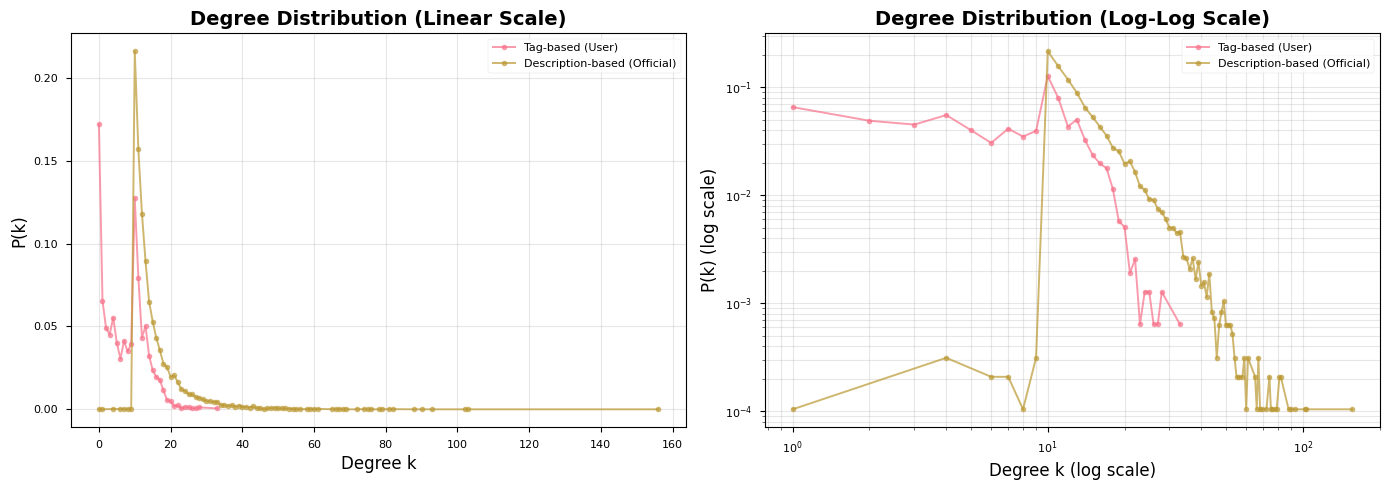


2. Network Statistics Comparison...
Saved to figures/network_density_comparison.png


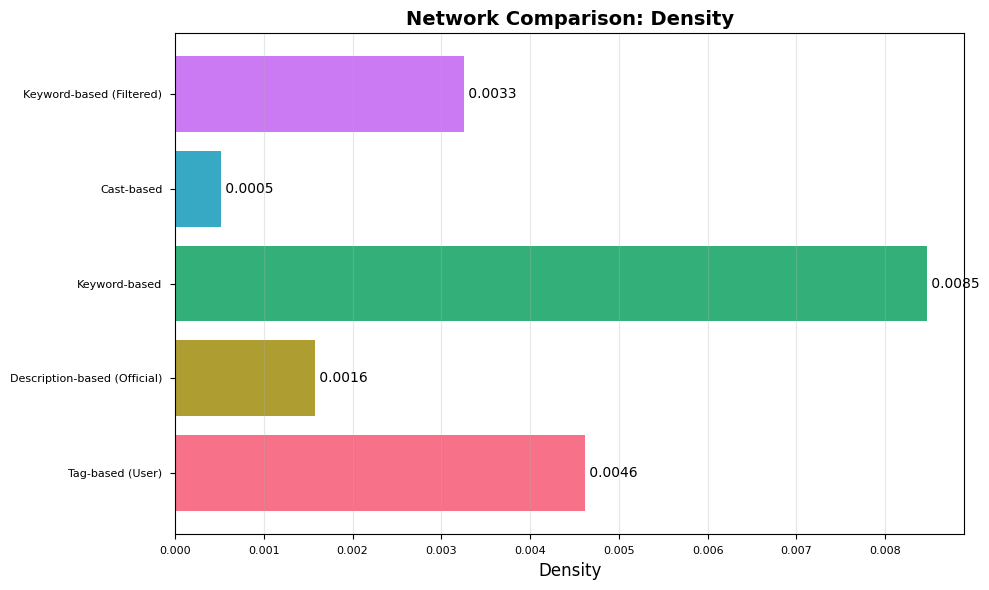


3. Community Similarity Heatmap...
Saved to figures/community_similarity_nmi.png


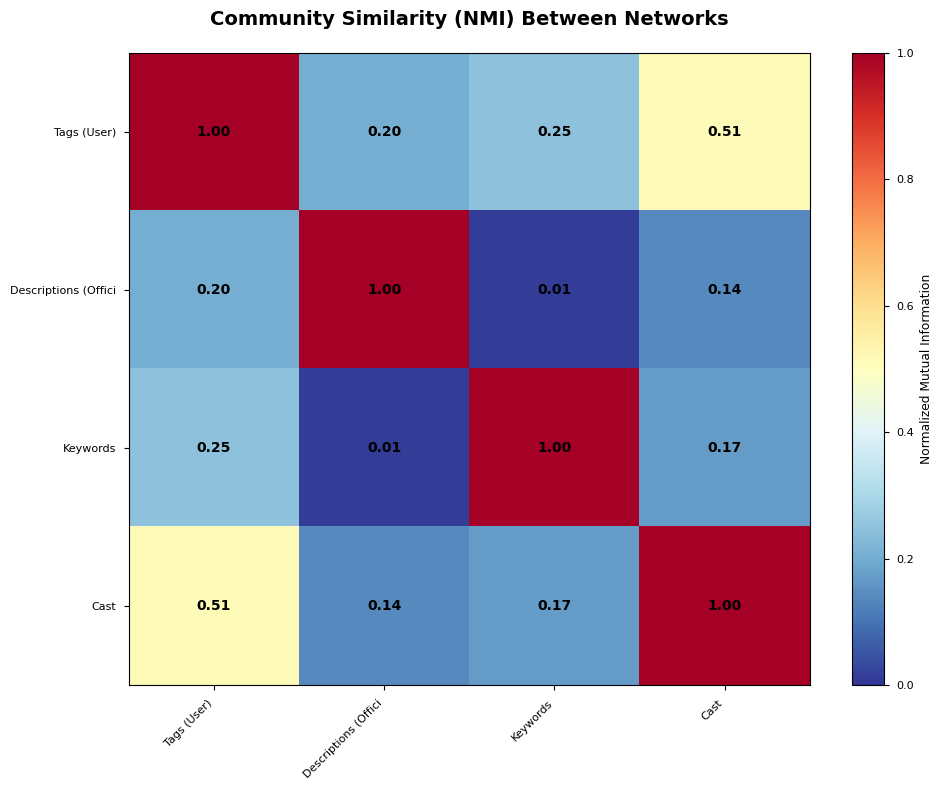


4. Centrality Correlation Heatmap...
Saved to figures/centrality_correlations.png


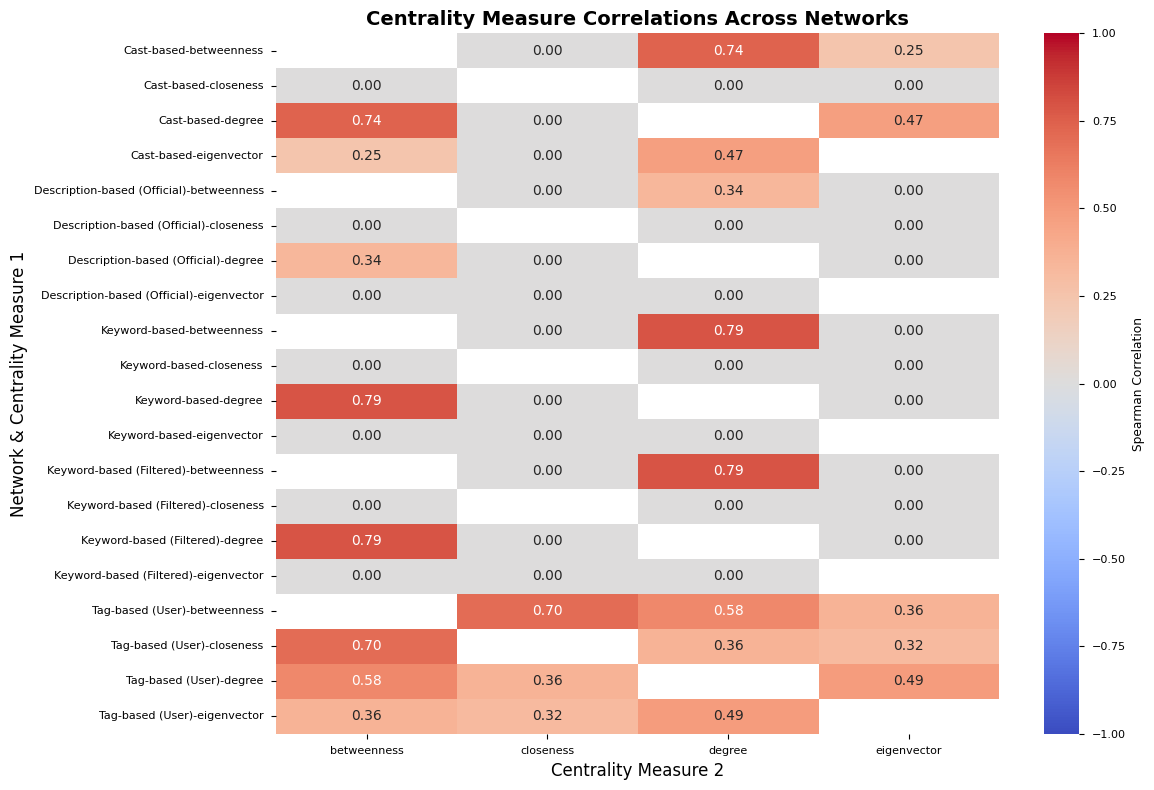

In [31]:

# Generate quality figures for the paper

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style for academic papers
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

def plot_degree_distributions(networks: Dict[str, nx.Graph], save_path: str = None):
    """
    Plot degree distributions for multiple networks (log-log scale).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Filter to key networks for comparison
    key_networks = {}
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        if 'Tag' in name or 'Description' in name or 'Official' in name:
            key_networks[name] = G
    
    if len(key_networks) < 2:
        print("Need at least 2 networks for comparison")
        return
    
    # Plot 1: Linear scale
    ax1 = axes[0]
    for name, G in list(key_networks.items())[:3]:  # Limit to 3 for clarity
        degrees = [d for n, d in G.degree()]
        unique, counts = np.unique(degrees, return_counts=True)
        probs = counts / len(degrees)
        ax1.plot(unique, probs, 'o-', label=name, alpha=0.7, markersize=4)
    
    ax1.set_xlabel('Degree k', fontsize=12)
    ax1.set_ylabel('P(k)', fontsize=12)
    ax1.set_title('Degree Distribution (Linear Scale)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Log-log scale (power-law check)
    ax2 = axes[1]
    for name, G in list(key_networks.items())[:3]:
        degrees = [d for n, d in G.degree()]
        unique, counts = np.unique(degrees, return_counts=True)
        probs = counts / len(degrees)
        
        # Filter zeros
        mask = (unique > 0) & (probs > 0)
        ax2.loglog(unique[mask], probs[mask], 'o-', label=name, alpha=0.7, markersize=4)
    
    ax2.set_xlabel('Degree k (log scale)', fontsize=12)
    ax2.set_ylabel('P(k) (log scale)', fontsize=12)
    ax2.set_title('Degree Distribution (Log-Log Scale)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

def plot_network_comparison_matrix(networks: Dict[str, nx.Graph], 
                                   metric_func, metric_name: str,
                                   save_path: str = None):
    """
    Create a heatmap comparing a metric across all networks.
    """
    network_names = []
    metric_values = []
    
    for name, G in networks.items():
        if G is None or G.number_of_nodes() == 0:
            continue
        try:
            value = metric_func(G)
            network_names.append(name)
            metric_values.append(value)
        except:
            continue
    
    if len(metric_values) < 2:
        print(f"Not enough data for {metric_name} comparison")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bar plot
    bars = ax.barh(network_names, metric_values, color=sns.color_palette("husl", len(metric_values)))
    ax.set_xlabel(metric_name, fontsize=12)
    ax.set_title(f'Network Comparison: {metric_name}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (name, value) in enumerate(zip(network_names, metric_values)):
        ax.text(value, i, f' {value:.4f}', va='center', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

def plot_community_comparison_heatmap(partitions: Dict[str, Dict], save_path: str = None):
    """
    Create NMI heatmap showing community similarity between networks.
    """
    network_names = list(partitions.keys())
    n = len(network_names)
    
    if n < 2:
        print("Need at least 2 networks for comparison")
        return
    
    nmi_matrix = np.zeros((n, n))
    
    for i, name1 in enumerate(network_names):
        for j, name2 in enumerate(network_names):
            if i == j:
                nmi_matrix[i, j] = 1.0
            elif i < j:
                nmi = compare_communities(partitions[name1], partitions[name2])
                nmi_matrix[i, j] = nmi
                nmi_matrix[j, i] = nmi
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Shorten names for display
    short_names = [name.replace('Tag-based (User)', 'Tags (User)')
                   .replace('Description-based (Official)', 'Descriptions (Official)')
                   .replace('Keyword-based', 'Keywords')
                   .replace('Cast-based', 'Cast')[:20] for name in network_names]
    
    im = ax.imshow(nmi_matrix, cmap='RdYlBu_r', vmin=0, vmax=1, aspect='auto')
    
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(short_names, rotation=45, ha='right')
    ax.set_yticklabels(short_names)
    
    # Add text annotations
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, f'{nmi_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontweight='bold')
    
    ax.set_title('Community Similarity (NMI) Between Networks', fontsize=14, fontweight='bold', pad=20)
    plt.colorbar(im, ax=ax, label='Normalized Mutual Information')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

def plot_centrality_correlation_heatmap(centrality_corrs: pd.DataFrame, save_path: str = None):
    """
    Plot correlation heatmap between centrality measures.
    """
    if len(centrality_corrs) == 0:
        print("No centrality correlation data available")
        return
    
    # Pivot for heatmap
    pivot_data = centrality_corrs.pivot_table(
        index=['network', 'centrality1'],
        columns='centrality2',
        values='correlation'
    )
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Spearman Correlation'})
    
    ax.set_title('Centrality Measure Correlations Across Networks', fontsize=14, fontweight='bold')
    ax.set_xlabel('Centrality Measure 2', fontsize=12)
    ax.set_ylabel('Network & Centrality Measure 1', fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    plt.show()

# Create figures directory
import os
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

# Generate visualizations
if 'networks' in globals() and networks:
    
    # Figure 1: Degree distributions
    print("\n1. Degree Distribution Comparison...")
    plot_degree_distributions(networks, save_path=figures_dir / "degree_distributions.png")
    
    # Figure 2: Network statistics comparison
    print("\n2. Network Statistics Comparison...")
    if 'stats_df' in globals() and len(stats_df) > 0:
        plot_network_comparison_matrix(
            networks,
            lambda G: nx.density(G) if G.number_of_nodes() > 0 else 0,
            "Density",
            save_path=figures_dir / "network_density_comparison.png"
        )
    
    # Figure 3: Community similarity
    print("\n3. Community Similarity Heatmap...")
    if 'partitions' in globals():
        plot_community_comparison_heatmap(
            partitions,
            save_path=figures_dir / "community_similarity_nmi.png"
        )
    
    # Figure 4: Centrality correlations
    print("\n4. Centrality Correlation Heatmap...")
    if 'centrality_corrs' in globals() and len(centrality_corrs) > 0:
        plot_centrality_correlation_heatmap(
            centrality_corrs,
            save_path=figures_dir / "centrality_correlations.png"
        )
    
else:
    print("Networks not found. Please run network construction cells first.")

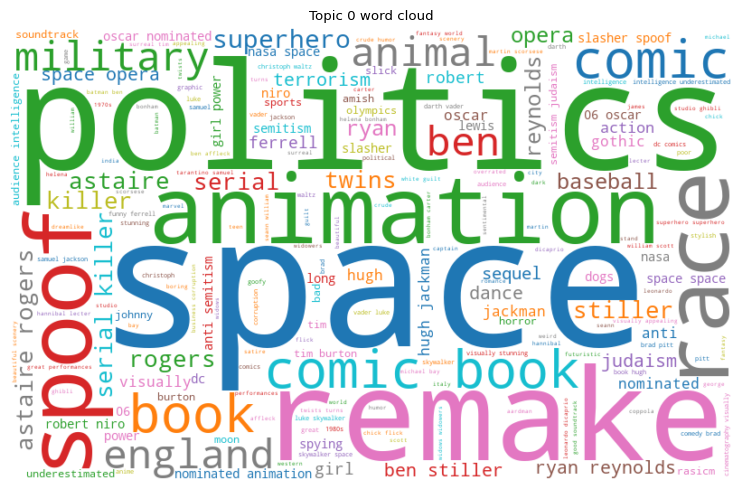

Saved: figures/topic_0_wordcloud.png


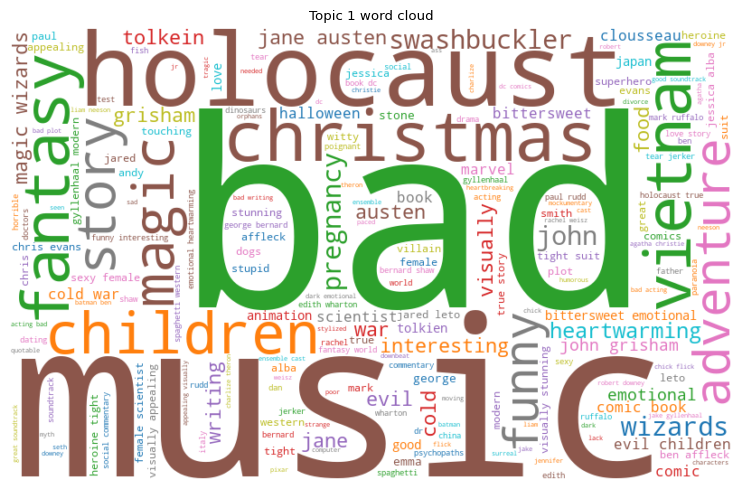

Saved: figures/topic_1_wordcloud.png


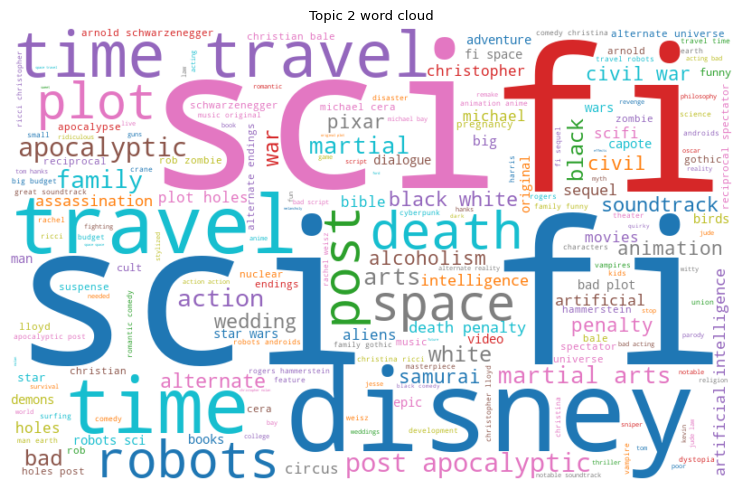

Saved: figures/topic_2_wordcloud.png


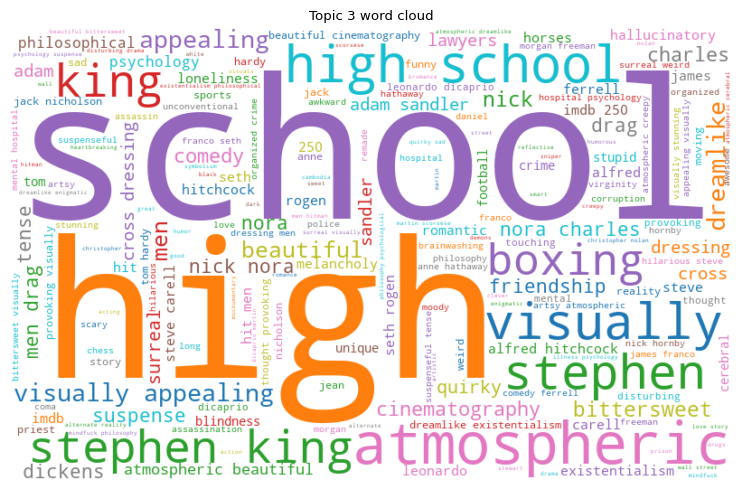

Saved: figures/topic_3_wordcloud.png


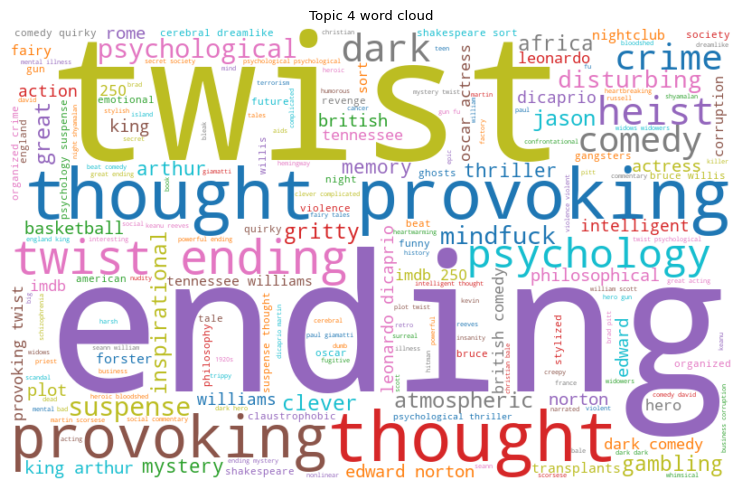

Saved: figures/topic_4_wordcloud.png


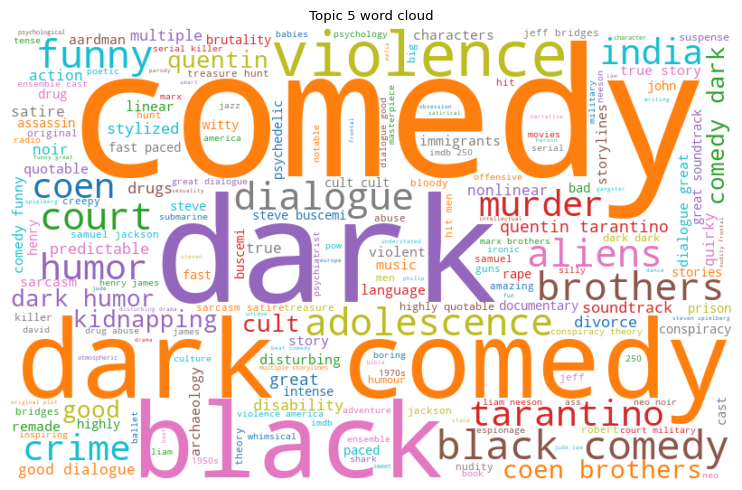

Saved: figures/topic_5_wordcloud.png


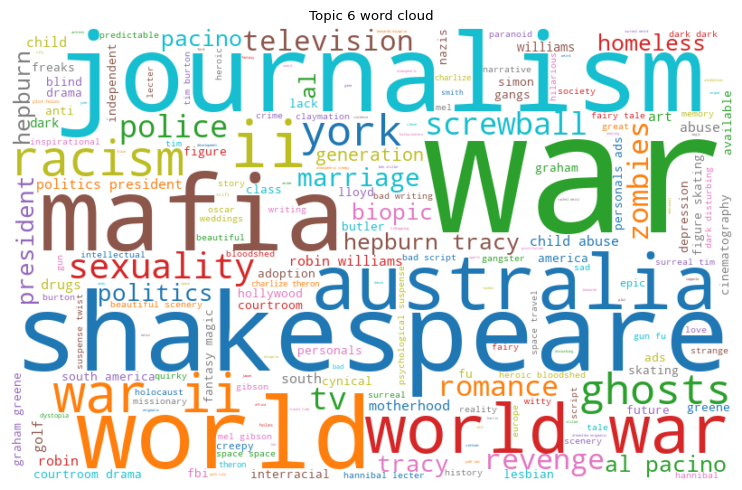

Saved: figures/topic_6_wordcloud.png


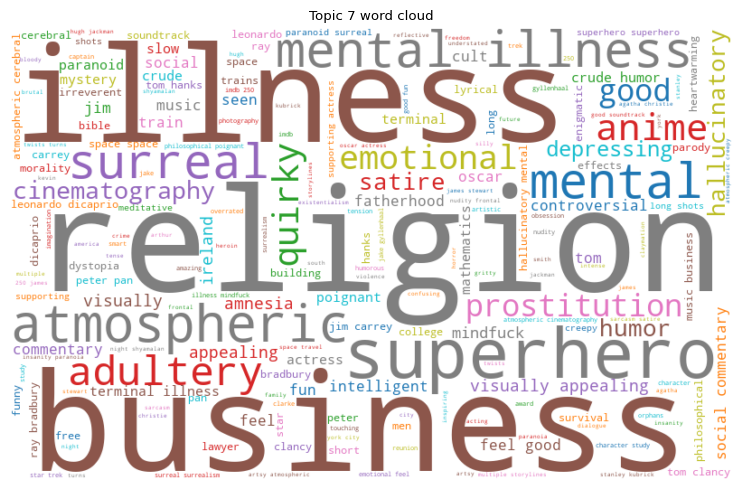

Saved: figures/topic_7_wordcloud.png


In [32]:
# Topic word clouds for top topics
from wordcloud import WordCloud

out_dir = BASE_DIR / "figures"
out_dir.mkdir(exist_ok=True)

# Build per-topic frequency dicts from H (topic-term weights)
terms = np.array(count_vectorizer.get_feature_names_out())
for k in range(n_topics):
    weights = H[k]
    top_idx = np.argsort(weights)[::-1][:200]
    freqs = {terms[i]: float(weights[i]) for i in top_idx}
    wc = WordCloud(width=800, height=500, background_color="white", colormap="tab10").generate_from_frequencies(freqs)
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {k} word cloud')
    plt.tight_layout()
    out_path = out_dir / f"topic_{k}_wordcloud.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)

